# Comparison with Variance-reduced Zeroth order
In this notebook, we propose some experiments in order to compare SSZD with its variance-reduced variant.

## Imports

In [1]:
import os
import numpy as np
from sszd import SSZD, SSVRZD
import matplotlib
import matplotlib.pyplot as plt
from experiments_utils.synthetic_functions import BenchmarkFunction

out_dir = "./results/variance_reduced"

os.makedirs(out_dir, exist_ok=True)

## Auxiliary functions and variables

In [2]:
class StronglyConvexFunction(BenchmarkFunction):
    
    def __init__(self, d, seed =12):
        super().__init__("StronglyConvex", d)
        self.rnd_state = np.random.RandomState(seed = seed)
        self.A = self.rnd_state.rand(d, d)
        
    def __call__(self, x, z = None):
        if z is None:
            return 1/self.d * (np.linalg.norm(self.A.dot(x))**2)
        row = self.A[z, :]
        return (np.linalg.norm(row.dot(x))**2)

In [3]:
d = 100 # dimensions
rnd_state = np.random.RandomState(seed=1212)
strong_conv_target = StronglyConvexFunction(d, seed=12)

In [4]:
import time

def execute_experiment(alg, target, budget, x, z = None, deterministic=False):
    y_fun = [target(x)]
    ctime = []
    for k in range(1, budget):
        it_time = time.time()
        x = alg.step(target, x, z)
        it_time = time.time() - it_time
        if not deterministic:
            z = rnd_state.randint(low=0, high=d)
        y_fun.append(target(x))
        ctime.append(it_time)
    ctime = np.cumsum(ctime)
    return y_fun, ctime

## Experiment with $\alpha = 1/\sqrt{k}$

In [2]:
# Parameters
A = strong_conv_target.A
w, _ = np.linalg.eigh(A.T.dot(A))

L = w[-1] / A.shape[0]
reps = 10

l = d//2

alpha = lambda k : 0.2 * l/(d * L) * 1/np.sqrt(k) #np.sqrt(k) # Step-size
alpha_det = lambda k : 0.1 * l/(d * L) #np.sqrt(k) # Step-size

h = lambda k : 1/k # Discretization parameter

y_ssvrzd_sph, ctime_ssvrzd_sph = [], []
y_sszd_sph, ctime_sszd_sph = [], []
y_szd_sph, ctime_szd_sph = [], []

sszd_sph = SSZD('spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)
szd_sph = SSZD('spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)
ssvrzd_sph = SSVRZD(5, False, 'spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)


for i in range(reps):
    x = np.asarray([10.0 for _ in range(d)])
    z = 0
    budget = 500 #5000
    print("[--] Episode: {}/{}".format(i, reps))
    sszd_y, sszd_time = execute_experiment(sszd_sph, strong_conv_target, budget, x, z)
    szd_y, szd_time = execute_experiment(szd_sph, strong_conv_target, budget, x, None, True)
    vr_y, vr_time = execute_experiment(ssvrzd_sph, strong_conv_target, budget, x, z)
    
    y_ssvrzd_sph.append(vr_y)
    ctime_ssvrzd_sph.append(vr_time)
    y_sszd_sph.append(sszd_y)
    ctime_sszd_sph.append(sszd_time)
    y_szd_sph.append(szd_y)
    ctime_szd_sph.append(szd_time)
    sszd_sph.reset()
    szd_sph.reset()
    ssvrzd_sph.reset()
print("[--] Done!")

NameError: name 'strong_conv_target' is not defined

In [168]:
# Collect y results
sph_mean, sph_std = np.mean(y_sszd_sph, axis=0), np.std(y_sszd_sph, axis=0)
sph_det_mean, sph_det_std = np.mean(y_szd_sph, axis=0), np.std(y_szd_sph, axis=0)
sph_vr_mean, sph_vr_std = np.mean(y_ssvrzd_sph, axis=0), np.std(y_ssvrzd_sph, axis=0)

# Collect y results
sph_mean_tm, sph_std_tm = np.mean(ctime_sszd_sph, axis=0), np.std(ctime_sszd_sph, axis=0)
sph_det_mean_tm, sph_det_std_tm = np.mean(ctime_szd_sph, axis=0), np.std(ctime_szd_sph, axis=0)
sph_vr_mean_tm, sph_vr_std_tm = np.mean(ctime_ssvrzd_sph, axis=0), np.std(ctime_ssvrzd_sph, axis=0)



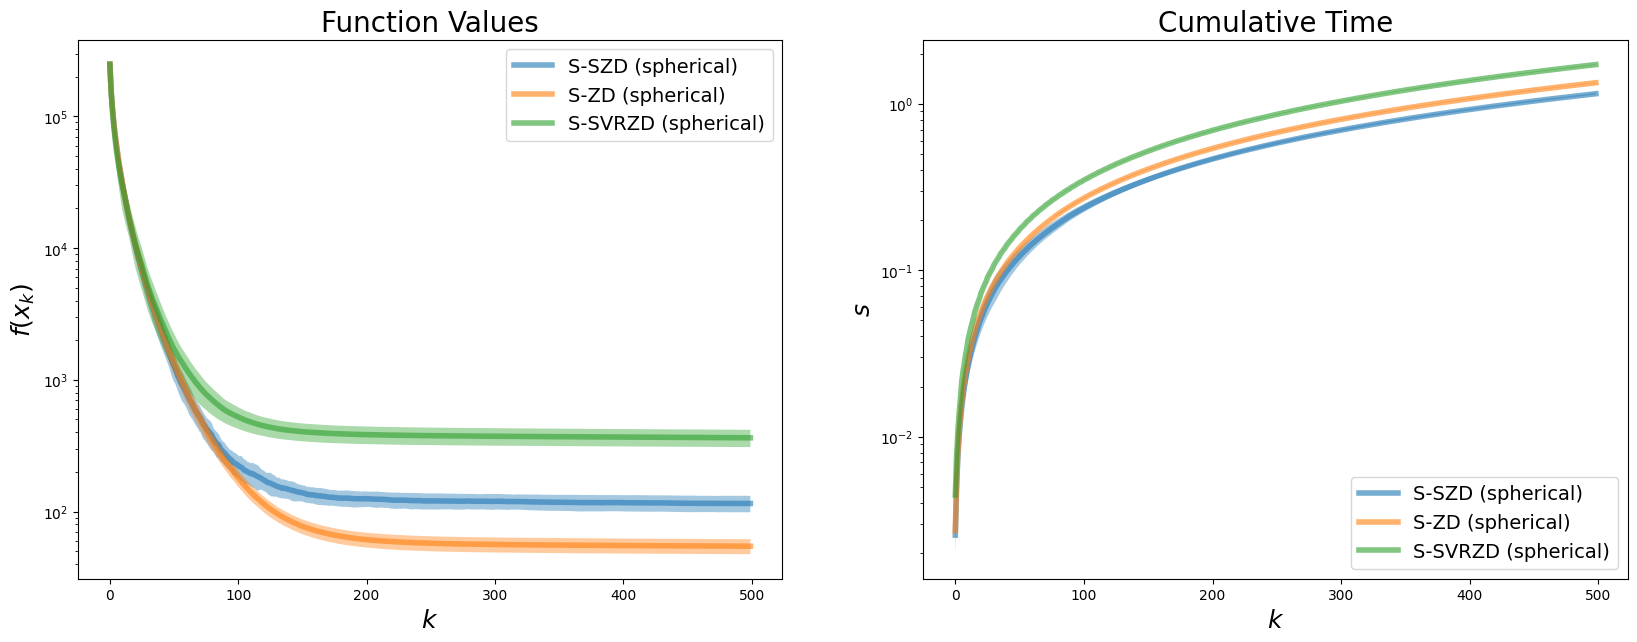

In [169]:

def plot_mean_std(ax, mean, std, label):
    ax.plot(range(len(mean)),   mean, '-', lw=4, alpha=0.6, label=label)
    ax.fill_between(range(len(mean)),  mean + std, mean - std, alpha=0.4)
   

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.set_title("Function Values", fontsize=20)
ax2.set_title("Cumulative Time", fontsize=20)

plot_mean_std(ax1, sph_mean, sph_std, label="S-SZD (spherical)")
plot_mean_std(ax1, sph_det_mean, sph_det_std, label="S-ZD (spherical)")
plot_mean_std(ax1, sph_vr_mean, sph_vr_std, label="S-SVRZD (spherical)")


plot_mean_std(ax2, sph_mean_tm, sph_std_tm, label="S-SZD (spherical)")
plot_mean_std(ax2, sph_det_mean_tm, sph_det_std_tm, label="S-ZD (spherical)")
plot_mean_std(ax2, sph_vr_mean_tm, sph_vr_std_tm, label="S-SVRZD (spherical)")




ax1.set_xlabel("$k$", fontsize=18)
ax1.set_ylabel("$f(x_k)$", fontsize=18)
ax2.set_xlabel("$k$", fontsize=18)
ax2.set_ylabel("$s$", fontsize=18)

ax1.legend(loc="upper right", fontsize=14)
ax1.set_yscale("log")
ax2.legend(loc="lower right", fontsize=14)
ax2.set_yscale("log")


In [162]:
def change_num_iters(num_iter, reps, budget):
    ssvrzd_sph = SSVRZD(num_iter, 'spherical', d, l,  alpha, h,  dtype = np.float64, seed = it)

    y_values = np.zeros((reps, budget))
    ctime = np.zeros((reps, budget-1))
    
    for i in range(reps):
        x = np.asarray([10.0 for _ in range(d)])
        z = 0
        print("[NI={}] Episode: {}/{}".format(num_iter, i, reps))
        vr_y, vr_time = execute_experiment(ssvrzd_sph, strong_conv_target, budget, x, z)
        y_values[i] = vr_y
        ctime[i] = vr_time
    ctime = np.cumsum(ctime, axis=1)
    return y_values.mean(axis=0), y_values.std(axis=0), ctime.mean(axis=0), ctime.std(axis=0)

reps = 10
budget = 500

iters = [1, 5, 10, 20]    

results = []
for it in iters:
    results.append(change_num_iters(it, reps, budget))

    
    

[NI=1] Episode: 0/10
[NI=1] Episode: 1/10
[NI=1] Episode: 2/10
[NI=1] Episode: 3/10
[NI=1] Episode: 4/10
[NI=1] Episode: 5/10
[NI=1] Episode: 6/10
[NI=1] Episode: 7/10
[NI=1] Episode: 8/10
[NI=1] Episode: 9/10
[NI=5] Episode: 0/10
[NI=5] Episode: 1/10
[NI=5] Episode: 2/10
[NI=5] Episode: 3/10
[NI=5] Episode: 4/10
[NI=5] Episode: 5/10
[NI=5] Episode: 6/10
[NI=5] Episode: 7/10
[NI=5] Episode: 8/10
[NI=5] Episode: 9/10
[NI=10] Episode: 0/10
[NI=10] Episode: 1/10
[NI=10] Episode: 2/10
[NI=10] Episode: 3/10
[NI=10] Episode: 4/10
[NI=10] Episode: 5/10
[NI=10] Episode: 6/10
[NI=10] Episode: 7/10
[NI=10] Episode: 8/10
[NI=10] Episode: 9/10
[NI=20] Episode: 0/10
[NI=20] Episode: 1/10
[NI=20] Episode: 2/10
[NI=20] Episode: 3/10
[NI=20] Episode: 4/10
[NI=20] Episode: 5/10
[NI=20] Episode: 6/10
[NI=20] Episode: 7/10
[NI=20] Episode: 8/10
[NI=20] Episode: 9/10


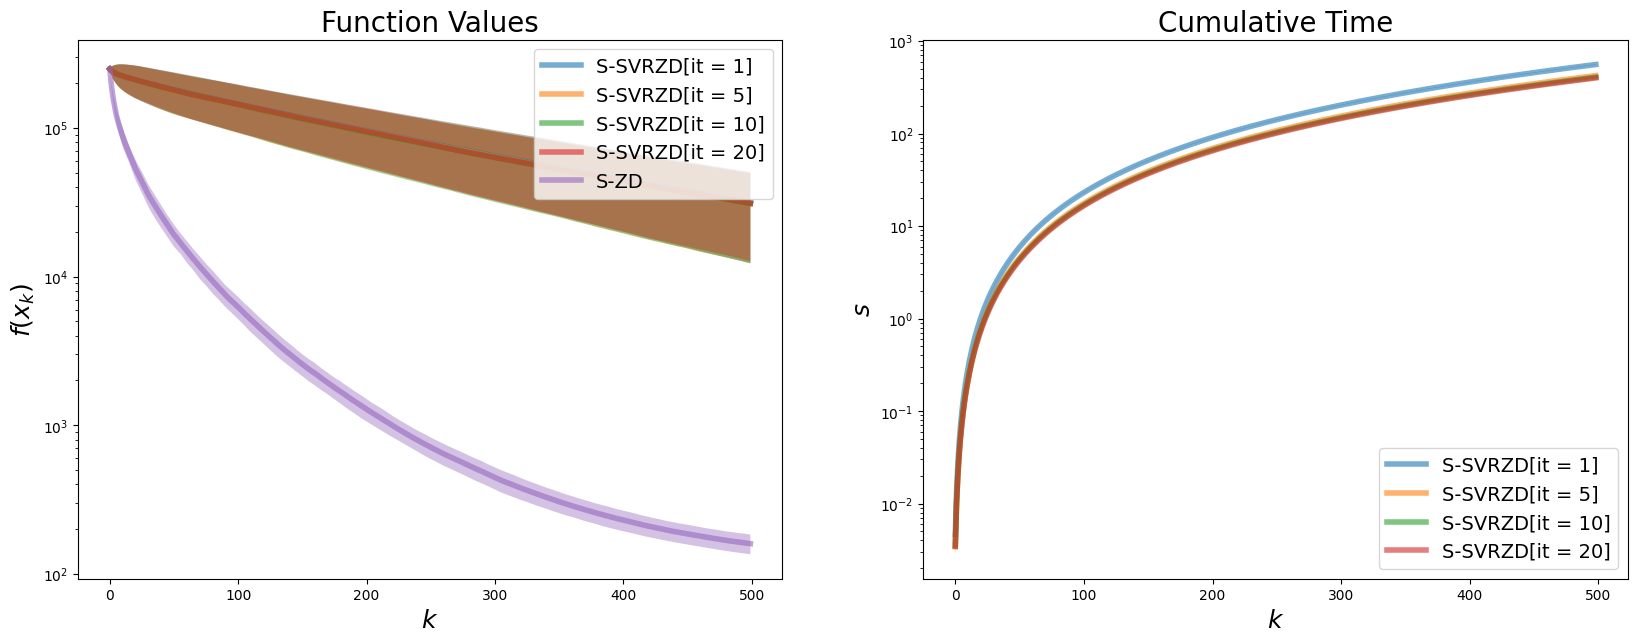

In [163]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.set_title("Function Values", fontsize=20)
ax2.set_title("Cumulative Time", fontsize=20)

for (it, ris) in zip(iters, results):
    y_mean, y_std, tm_mean, tm_std = ris
    
    plot_mean_std(ax1, y_mean , y_std, label="S-SVRZD[it = {}]".format(it))
    plot_mean_std(ax2, tm_mean, tm_std, label="S-SVRZD[it = {}]".format(it))

plot_mean_std(ax1, sph_vr_mean, sph_vr_std, label="S-ZD")



ax1.set_xlabel("$k$", fontsize=18)
ax1.set_ylabel("$f(x_k)$", fontsize=18)
ax2.set_xlabel("$k$", fontsize=18)
ax2.set_ylabel("$s$", fontsize=18)

ax1.legend(loc="upper right", fontsize=14)
ax1.set_yscale("log")
ax2.legend(loc="lower right", fontsize=14)
ax2.set_yscale("log")


In [6]:
d = 1
rnd_state = np.random.RandomState(12)

w = rnd_state.rand(d, 1)

def generate_data(n_points, w, rnd_state, sigma_noise=0.1):
    X = np.zeros((n_points, d))
    for i in range(d):
        X[:, i] = rnd_state.uniform(0, 1, size=n_points)
    
    gauss_noise = rnd_state.normal(0, sigma_noise, size=(n_points, 1))

    y = np.dot(X, w) + gauss_noise
    
    return X, y    

n_points = 1000
    
X, y = generate_data(n_points, w, rnd_state, sigma_noise=0.01)
    
    
#_, ax = plt.subplots()
#ax.plot(X, y, 'o')

    
    

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)


print(w)

[[0.15416284]]


In [8]:
def mse(y, y_pred):
    return ((y - y_pred)**2).mean()

def target(w, z = None):
    w = w.reshape(-1, 1)
    if z is None:
        X, y = X_train, y_train
    else:
        X, y = z
    y_pred = X.dot(w)
    return mse(y, y_pred)



l = d

L =  np.max(np.linalg.eigvals(X_train.T.dot(X_train)))

alpha = lambda k : 0.5 *  l/d * 1/np.sqrt(k)
h = lambda k : 1/k

rnd_state = np.random.RandomState(12)
T = 500

reps = 50
num_iters = 100

results = {
    'szd' : [[] for _ in range(reps)],
    'sszd' : [[] for _ in range(reps)],
    'ssvrzd_full_iter' : [[] for _ in range(reps)],
    'ssvrzd_only_iter' : [[] for _ in range(reps)],
}

def update_results(name, w, r):
    results[name][r].append(target(w, (X_train, y_train)))


szd = SSZD('coordinate', d, l,  alpha, h,  dtype = np.float64, seed = 12)
sszd = SSZD('coordinate', d, l,  alpha, h,  dtype = np.float64, seed = 12)
ssvrzd = SSVRZD(num_iters, False, 'coordinate', d, l,  alpha, h,  dtype = np.float64, seed = 12)
ssvrzd_2 = SSVRZD(num_iters, True, 'coordinate', d, l,  alpha, h,  dtype = np.float64, seed = 12)


for r in range(reps):
    w_k_szd = np.zeros(d) + 20
    w_k_sszd = np.zeros(d) + 20
    w_k_ssvrzd = np.zeros(d) + 20
    w_k_ssvrzd_2 = np.zeros(d) + 20


    update_results("szd", w_k_szd, r)
    update_results("sszd", w_k_sszd, r)
    update_results("ssvrzd_full_iter", w_k_ssvrzd, r)
    update_results("ssvrzd_only_iter", w_k_ssvrzd_2, r)

    for t in range(T):
        z = rnd_state.randint(low=0, high=X_train.shape[0])
        w_k_sszd = szd.step(target, w_k_sszd, (X_train[z,:], y_train[z]))
        w_k_szd = sszd.step(target, w_k_szd, (X_train, y_train))
        w_k_ssvrzd = ssvrzd.step(target, w_k_ssvrzd, (X_train[z,:], y_train[z]))
        w_k_ssvrzd_2 = ssvrzd_2.step(target, w_k_ssvrzd_2, (X_train[z,:], y_train[z]))

        update_results("szd", w_k_szd, r)
        update_results("sszd", w_k_sszd, r)
        update_results("ssvrzd_full_iter", w_k_ssvrzd, r)
        update_results("ssvrzd_only_iter", w_k_ssvrzd_2, r)

    szd.reset()
    sszd.reset()
    ssvrzd.reset()
    ssvrzd_2.reset()
#print(w_k_sszd, w_k_szd)


[--] Old diff: 4.236888885314045
[--] Old diff: 4.236888885314045
[--] Old diff: 7.3905439965069775
[--] Old diff: 7.3905439965069775
[--] Old diff: 2.0262151430524113
[--] Old diff: 2.0262151430524113
[--] Old diff: 7.1879129777525606
[--] Old diff: 7.1879129777525606
[--] Old diff: 11.731388289825599
[--] Old diff: 11.731388289825599
[--] Old diff: 24.88259899490069
[--] Old diff: 24.88259899490069
[--] Old diff: 18.35636429472177
[--] Old diff: 18.35636429472177
[--] Old diff: 10.257234660364901
[--] Old diff: 10.257234660364901
[--] Old diff: 16.3365383357868
[--] Old diff: 16.3365383357868
[--] Old diff: 13.52716296603051
[--] Old diff: 13.52716296603051
[--] Old diff: 3.657950229843152
[--] Old diff: 3.657950229843152
[--] Old diff: 9.809264042797928
[--] Old diff: 9.809264042797928
[--] Old diff: 18.39259095596654
[--] Old diff: 18.39259095596654
[--] Old diff: 0.4383690316775244
[--] Old diff: 0.4383690316775244
[--] Old diff: 4.006951277050348
[--] Old diff: 4.006951277050348


[--] Old diff: 0.005873683457714593
[--] Old diff: 0.7892988747053744
[--] Old diff: 0.010139893392190857
[--] Old diff: 4.281431186082054
[--] Old diff: 0.0009706958323183468
[--] Old diff: 1.493275209774847
[--] Old diff: 0.008171300388643029
[--] Old diff: 5.4785562510656
[--] Old diff: 0.036681988174456406
[--] Old diff: 1.4264700493504758
[--] Old diff: 0.02672153405293303
[--] Old diff: 3.437877366683398
[--] Old diff: 0.014824536253991391
[--] Old diff: 0.5426762182804724
[--] Old diff: 0.001597865721053052
[--] Old diff: 0.6399398938772192
[--] Old diff: 0.017470054632298945
[--] Old diff: 1.0528805626912112
[--] Old diff: 0.006162776322551218
[--] Old diff: 0.5562671771882736
[--] Old diff: 0.0016576701052642316
[--] Old diff: 0.7695910807561883
[--] Old diff: 0.0042980799790308674
[--] Old diff: 0.5535292961344473
[--] Old diff: 0.00288726677816816
[--] Old diff: 0.565379160939565
[--] Old diff: 0.0009200547972575338
[--] Old diff: 0.18141687263494405
[--] Old diff: 0.0087270

[--] Old diff: 0.0008844330223109972
[--] Old diff: 0.011061439369090858
[--] Old diff: 0.05245802031117614
[--] Old diff: 0.00281837353979223
[--] Old diff: 0.03894519932452554
[--] Old diff: 5.941678858387069e-05
[--] Old diff: 0.06960446879336321
[--] Old diff: 0.009862767364316176
[--] Old diff: 0.06979109670305098
[--] Old diff: 0.01122301463333033
[--] Old diff: 0.06960446879336321
[--] Old diff: 0.009862767364316176
[--] Old diff: 0.06563363807247696
[--] Old diff: 0.00850571501385574
[--] Old diff: 0.019037601590559457
[--] Old diff: 0.00648912747373401
[--] Old diff: 0.013733736746355349
[--] Old diff: 0.006201412434954816
[--] Old diff: 0.03371323674824377
[--] Old diff: 6.319237045655232e-05
[--] Old diff: 0.027008936692607087
[--] Old diff: 0.00023617001381527093
[--] Old diff: 0.058479852687448944
[--] Old diff: 0.0010120328631701085
[--] Old diff: 0.07361991797399936
[--] Old diff: 0.01170924779821934
[--] Old diff: 0.017707428995889486
[--] Old diff: 0.01292842766029579


[--] Old diff: 8.837274643460688
[--] Old diff: 8.837274643460688
[--] Old diff: 20.893575521026065
[--] Old diff: 20.893575521026065
[--] Old diff: 1.19200916305914
[--] Old diff: 1.19200916305914
[--] Old diff: 14.88708694675833
[--] Old diff: 14.88708694675833
[--] Old diff: 7.13234679300092
[--] Old diff: 7.13234679300092
[--] Old diff: 12.33918844745325
[--] Old diff: 12.33918844745325
[--] Old diff: 3.3331053797369066
[--] Old diff: 3.3331053797369066
[--] Old diff: 0.801442345876012
[--] Old diff: 0.801442345876012
[--] Old diff: 12.085131057163153
[--] Old diff: 12.085131057163153
[--] Old diff: 7.922682120240474
[--] Old diff: 7.922682120240474
[--] Old diff: 12.992275962427158
[--] Old diff: 12.992275962427158
[--] Old diff: 15.309819382717166
[--] Old diff: 15.309819382717166
[--] Old diff: 5.990074786957905
[--] Old diff: 5.990074786957905
[--] Old diff: 13.075634663069987
[--] Old diff: 13.075634663069987
[--] Old diff: 14.053271116328993
[--] Old diff: 14.053271116328993


[--] Old diff: 0.023320405908408406
[--] Old diff: 0.001622318724084902
[--] Old diff: 0.028930709811830227
[--] Old diff: 0.0016617989870732056
[--] Old diff: 0.03312280772053887
[--] Old diff: 0.00040201618206311875
[--] Old diff: 0.033037765543719386
[--] Old diff: 0.002268255290875908
[--] Old diff: 0.04367838049000483
[--] Old diff: 0.003574446579396437
[--] Old diff: 0.01774279370948353
[--] Old diff: 0.003095614841920735
[--] Old diff: 0.030880092798013906
[--] Old diff: 2.004184007718549e-05
[--] Old diff: 0.031115273568861256
[--] Old diff: 0.0027338851417763993
[--] Old diff: 0.02096872373592371
[--] Old diff: 0.0019224785393697863
[--] Old diff: 0.027369496494543975
[--] Old diff: 0.0017670116396561997
[--] Old diff: 0.01135817787497466
[--] Old diff: 0.010665492601847914
[--] Old diff: 0.02020321421825052
[--] Old diff: 0.013247129852450948
[--] Old diff: 0.04088118570276425
[--] Old diff: 0.0012460404710805473
[--] Old diff: 0.020874851390253024
[--] Old diff: 0.0187496655

[--] Old diff: 0.0001449717643058604
[--] Old diff: 0.00024715323188315293
[--] Old diff: 3.337389291608416e-05
[--] Old diff: 0.000434421536213057
[--] Old diff: 0.003327300692189997
[--] Old diff: 0.003650381927978663
[--] Old diff: 0.0002234086299155839
[--] Old diff: 0.00017282514358939405
[--] Old diff: 0.015021018329074706
[--] Old diff: 0.014896538648304092
[--] Old diff: 0.0129016893814724
[--] Old diff: 0.013011609260113775
[--] Old diff: 0.008253167537713898
[--] Old diff: 0.00797013221727892
[--] Old diff: 0.0008442552563762144
[--] Old diff: 0.0012416571373917522
[--] Old diff: 0.004774536296797939
[--] Old diff: 0.004405295802295349
[--] Old diff: 0.002592853212492871
[--] Old diff: 0.003265657021481185
[--] Old diff: 0.0002250914023912003
[--] Old diff: 5.461684773844374e-05
[--] Old diff: 0.001680801590975112
[--] Old diff: 0.0020592877881706983
[--] Old diff: 0.0018925836201899617
[--] Old diff: 0.0014886999303549459
[--] Old diff: 0.015590128307282455
[--] Old diff: 0.

[--] Old diff: 1.0878439705218574
[--] Old diff: 0.08890465923749677
[--] Old diff: 0.2017189316970751
[--] Old diff: 0.007979470149445153
[--] Old diff: 0.98963290846601
[--] Old diff: 0.0823043589967516
[--] Old diff: 0.8452878896614655
[--] Old diff: 0.05245861992479328
[--] Old diff: 0.5790805018268177
[--] Old diff: 0.05112975608417585
[--] Old diff: 1.0881313775740384
[--] Old diff: 0.09038742656139469
[--] Old diff: 1.3328382748017331
[--] Old diff: 0.11069548138020471
[--] Old diff: 1.2630600567347816
[--] Old diff: 0.11242176689464742
[--] Old diff: 0.5749221149712002
[--] Old diff: 0.051265715299640996
[--] Old diff: 0.3690752917178778
[--] Old diff: 0.03871987648327937
[--] Old diff: 0.12095422119685273
[--] Old diff: 0.008085494998366277
[--] Old diff: 1.0053583106276576
[--] Old diff: 0.08035912331088273
[--] Old diff: 1.0861939866367827
[--] Old diff: 0.07284912485621814
[--] Old diff: 0.3378683410316733
[--] Old diff: 0.031430135333974096
[--] Old diff: 0.123106006117121

[--] Old diff: 0.0028486695048311646
[--] Old diff: 0.005944095531794062
[--] Old diff: 0.00017193535632487955
[--] Old diff: 0.003173462246380802
[--] Old diff: 0.0021710472435545556
[--] Old diff: 0.0026528273453714753
[--] Old diff: 0.0021240254788131695
[--] Old diff: 0.0015914149915913361
[--] Old diff: 0.007746514600796265
[--] Old diff: 0.011805255712805576
[--] Old diff: 0.014424823887159237
[--] Old diff: 0.011503979212593959
[--] Old diff: 0.013889207200733618
[--] Old diff: 0.0157552979441526
[--] Old diff: 0.01760420267854131
[--] Old diff: 0.019377672116311567
[--] Old diff: 0.011878084594909445
[--] Old diff: 0.009791143748900418
[--] Old diff: 0.005082612636809158
[--] Old diff: 0.0002831226179938109
[--] Old diff: 0.0019012817683580555
[--] Old diff: 0.0010602895155695342
[--] Old diff: 0.0020568500300838536
[--] Old diff: 0.0015715028556643848
[--] Old diff: 0.009178367816733715
[--] Old diff: 0.007679115878362466
[--] Old diff: 0.0028084053133493607
[--] Old diff: 0.0

[--] Old diff: 20.121162756903544
[--] Old diff: 20.121162756903544
[--] Old diff: 8.413454740888398
[--] Old diff: 8.413454740888398
[--] Old diff: 13.06282224275666
[--] Old diff: 13.06282224275666
[--] Old diff: 3.2104952400544704
[--] Old diff: 3.2104952400544704
[--] Old diff: 13.941531336470721
[--] Old diff: 13.941531336470721
[--] Old diff: 9.067135794893375
[--] Old diff: 9.067135794893375
[--] Old diff: 11.838719054635014
[--] Old diff: 11.838719054635014
[--] Old diff: 13.411407630270702
[--] Old diff: 13.411407630270702
[--] Old diff: 8.83943763017379
[--] Old diff: 8.83943763017379
[--] Old diff: 12.544389396205204
[--] Old diff: 12.544389396205204
[--] Old diff: 19.45795614126999
[--] Old diff: 19.45795614126999
[--] Old diff: 10.193839712153775
[--] Old diff: 10.193839712153775
[--] Old diff: 1.8456371721231903
[--] Old diff: 1.8456371721231903
[--] Old diff: 7.922682120240474
[--] Old diff: 7.922682120240474
[--] Old diff: 0.27978688202372837
[--] Old diff: 0.2797868820

[--] Old diff: 0.0029287326694760665
[--] Old diff: 0.009407817608205542
[--] Old diff: 0.008291557532230247
[--] Old diff: 0.04237052686477708
[--] Old diff: 0.040720995860451484
[--] Old diff: 0.010424822119691805
[--] Old diff: 0.012360696782203893
[--] Old diff: 0.00055207693856357
[--] Old diff: 0.0005722205242628172
[--] Old diff: 0.017178472602931708
[--] Old diff: 0.015206323320987696
[--] Old diff: 0.0043112008545384585
[--] Old diff: 0.003191729585370558
[--] Old diff: 0.004335800931897536
[--] Old diff: 0.00596011985369205
[--] Old diff: 0.033163790136472894
[--] Old diff: 0.03106101525185445
[--] Old diff: 0.009092171120836774
[--] Old diff: 0.009369046380641396
[--] Old diff: 0.003060297080670843
[--] Old diff: 0.002221044617356594
[--] Old diff: 0.02482250140129333
[--] Old diff: 0.024912404569376607
[--] Old diff: 0.009976515133248192
[--] Old diff: 0.008474441770473008
[--] Old diff: 0.010375020816603391
[--] Old diff: 0.010190686711249942
[--] Old diff: 0.0405107281389

[--] Old diff: 0.007979981840645498
[--] Old diff: 0.007848113859754341
[--] Old diff: 0.012737563150004443
[--] Old diff: 0.012915131591987958
[--] Old diff: 0.014834316517449209
[--] Old diff: 0.01607515161033355
[--] Old diff: 0.00524933456647127
[--] Old diff: 0.004855058141413885
[--] Old diff: 0.0036218309681817513
[--] Old diff: 0.004329978638161524
[--] Old diff: 0.02264128494585426
[--] Old diff: 0.022745008741552705
[--] Old diff: 0.0013667090453138957
[--] Old diff: 0.0020709603180450596
[--] Old diff: 0.00042592018261383637
[--] Old diff: 0.0008570119898162428
[--] Old diff: 0.0016308328623308899
[--] Old diff: 0.0011090120349217009
[--] Old diff: 0.0036086300477392564
[--] Old diff: 0.004002405699386176
[--] Old diff: 0.0046145157535314625
[--] Old diff: 0.0039004979324344918
[--] Old diff: 0.035584766286031695
[--] Old diff: 0.034550907040092525
[--] Old diff: 0.011279044919361787
[--] Old diff: 0.01152157414911547
[--] Old diff: 0.006086793133304076
[--] Old diff: 0.0056

[--] Old diff: 0.9190077266697696
[--] Old diff: 0.0010007345892237588
[--] Old diff: 1.2840847369671424
[--] Old diff: 0.003450206026178959
[--] Old diff: 1.444506190897728
[--] Old diff: 0.008886390249160877
[--] Old diff: 1.5146383336167253
[--] Old diff: 0.007701103577342326
[--] Old diff: 2.931212358759553
[--] Old diff: 0.001283428900296855
[--] Old diff: 1.5688700729486493
[--] Old diff: 0.0080312214932224
[--] Old diff: 0.33521944410838733
[--] Old diff: 0.002585698430772197
[--] Old diff: 1.8973205107243851
[--] Old diff: 0.012039657238304082
[--] Old diff: 3.343681676268287
[--] Old diff: 0.05631779094268577
[--] Old diff: 1.9374672487521516
[--] Old diff: 0.0049579527442459165
[--] Old diff: 1.9304499097232903
[--] Old diff: 0.007271316696717791
[--] Old diff: 1.7778022233918644
[--] Old diff: 0.01700834576472708
[--] Old diff: 1.8594256459616179
[--] Old diff: 0.004201665699449126
[--] Old diff: 1.6544681963478942
[--] Old diff: 0.0047305132166958665
[--] Old diff: 1.822280

[--] Old diff: 0.026682035106326902
[--] Old diff: 0.02772391891613503
[--] Old diff: 0.0020830071253489352
[--] Old diff: 0.003061793387997157
[--] Old diff: 0.0017128412351991036
[--] Old diff: 0.0014508423049245356
[--] Old diff: 0.0003446515675791257
[--] Old diff: 0.0007435934935121428
[--] Old diff: 0.014156761720265004
[--] Old diff: 0.012330918269156485
[--] Old diff: 0.003437276535401652
[--] Old diff: 0.004257481844454165
[--] Old diff: 0.003813407506783636
[--] Old diff: 0.0029840048344868873
[--] Old diff: 0.0021767835750077487
[--] Old diff: 0.004062044965586773
[--] Old diff: 0.001590597468840259
[--] Old diff: 0.0025733532702668454
[--] Old diff: 0.000526229603732287
[--] Old diff: 0.0005013935689720473
[--] Old diff: 0.025771682267582335
[--] Old diff: 0.02509128569357976
[--] Old diff: 0.0031972398019609123
[--] Old diff: 0.0028555191531191874
[--] Old diff: 0.01069605279261531
[--] Old diff: 0.01147989262376533
[--] Old diff: 0.00046497687565062333
[--] Old diff: 0.00

[--] Old diff: 7.344746840836478
[--] Old diff: 7.344746840836478
[--] Old diff: 10.393130575205522
[--] Old diff: 10.393130575205522
[--] Old diff: 8.537560593631156
[--] Old diff: 8.537560593631156
[--] Old diff: 7.71174953311467
[--] Old diff: 7.71174953311467
[--] Old diff: 2.6389160333644526
[--] Old diff: 2.6389160333644526
[--] Old diff: 8.621516421882603
[--] Old diff: 8.621516421882603
[--] Old diff: 12.659605808312422
[--] Old diff: 12.659605808312422
[--] Old diff: 12.537772108732884
[--] Old diff: 12.537772108732884
[--] Old diff: 4.005898746422602
[--] Old diff: 4.005898746422602
[--] Old diff: 12.634390585362254
[--] Old diff: 12.634390585362254
[--] Old diff: 12.752187960266696
[--] Old diff: 12.752187960266696
[--] Old diff: 0.23252156999859608
[--] Old diff: 0.23252156999859608
[--] Old diff: 4.892476940967981
[--] Old diff: 4.892476940967981
[--] Old diff: 21.624248019239275
[--] Old diff: 21.624248019239275
[--] Old diff: 4.717720751796605
[--] Old diff: 4.7177207517

[--] Old diff: 0.02456676231533702
[--] Old diff: 0.0026021414831849327
[--] Old diff: 0.02456676231533702
[--] Old diff: 0.0026021414831849327
[--] Old diff: 0.019245929320944943
[--] Old diff: 0.027339142514948216
[--] Old diff: 0.008127007493560767
[--] Old diff: 0.018338111210109365
[--] Old diff: 0.03035198846214217
[--] Old diff: 0.002854728595670086
[--] Old diff: 0.026732930507618186
[--] Old diff: 9.244792156731362e-05
[--] Old diff: 0.026768611190489365
[--] Old diff: 0.00106731501365177
[--] Old diff: 0.0317536515378876
[--] Old diff: 0.002865720423496278
[--] Old diff: 0.02888990649210176
[--] Old diff: 0.0044017718349259214
[--] Old diff: 0.026632970882517804
[--] Old diff: 0.0012856950195943946
[--] Old diff: 0.023731947407574887
[--] Old diff: 0.00742199712161058
[--] Old diff: 0.016590447795502866
[--] Old diff: 0.0011152545987053377
[--] Old diff: 0.020214211722075846
[--] Old diff: 0.013293033229528028
[--] Old diff: 0.003031870991870047
[--] Old diff: 0.0114971640003

[--] Old diff: 0.0018281915398861439
[--] Old diff: 0.0006027515681187584
[--] Old diff: 0.0034543750987049153
[--] Old diff: 0.0024739615258577785
[--] Old diff: 0.012167683237620604
[--] Old diff: 0.013013740932036683
[--] Old diff: 0.0005468726494018728
[--] Old diff: 0.0005660744301353422
[--] Old diff: 0.00793212072041809
[--] Old diff: 0.008352239181588143
[--] Old diff: 0.0010041584201059834
[--] Old diff: 0.0018471639219210974
[--] Old diff: 0.0037740581125505135
[--] Old diff: 0.0031407306408994537
[--] Old diff: 0.010742725805197266
[--] Old diff: 0.010825746696265286
[--] Old diff: 0.003181523579819795
[--] Old diff: 0.004196379368437418
[--] Old diff: 0.0301872762248462
[--] Old diff: 0.029728660654955927
[--] Old diff: 0.004483925352258696
[--] Old diff: 0.004014251209418272
[--] Old diff: 0.004114839424672133
[--] Old diff: 0.004832970528968044
[--] Old diff: 0.00010289072421257707
[--] Old diff: 0.0009312585635630334
[--] Old diff: 0.004341710326785326
[--] Old diff: 0.0

[--] Old diff: 14.032930935295699
[--] Old diff: 14.032930935295699
[--] Old diff: 2.4358391257853924
[--] Old diff: 2.4358391257853924
[--] Old diff: 11.362723748588522
[--] Old diff: 11.362723748588522
[--] Old diff: 12.741114076096164
[--] Old diff: 12.741114076096164
[--] Old diff: 14.265154569200535
[--] Old diff: 14.265154569200535
[--] Old diff: 15.854308159971737
[--] Old diff: 15.854308159971737
[--] Old diff: 7.669050418374482
[--] Old diff: 7.669050418374482
[--] Old diff: 4.404159629271845
[--] Old diff: 4.404159629271845
[--] Old diff: 25.666245398460234
[--] Old diff: 25.666245398460234
[--] Old diff: 13.119031942591537
[--] Old diff: 13.119031942591537
[--] Old diff: 1.5096440390685466
[--] Old diff: 0.003521566539282113
[--] Old diff: 1.2441540660944639
[--] Old diff: 0.00848276214495035
[--] Old diff: 0.40367439548817674
[--] Old diff: 0.011479683817423696
[--] Old diff: 1.5847452870371816
[--] Old diff: 0.008101338895133158
[--] Old diff: 2.537913361294204
[--] Old di

[--] Old diff: 0.02347596707480499
[--] Old diff: 0.012145532158223612
[--] Old diff: 0.04856583731698636
[--] Old diff: 0.024429399860918116
[--] Old diff: 0.0006697685108938978
[--] Old diff: 0.0011558378992799195
[--] Old diff: 0.0243110456433632
[--] Old diff: 0.00043836901866225195
[--] Old diff: 0.03874183706412868
[--] Old diff: 0.0052317683954771835
[--] Old diff: 0.041138620064234854
[--] Old diff: 0.013116805632439608
[--] Old diff: 0.002352581780629706
[--] Old diff: 0.01125726686421463
[--] Old diff: 0.05390572740381947
[--] Old diff: 0.017841637935998255
[--] Old diff: 0.0033939653706890754
[--] Old diff: 0.01447863778826214
[--] Old diff: 0.024302688728140835
[--] Old diff: 0.008954938891822322
[--] Old diff: 0.02847981961699144
[--] Old diff: 0.016294225891948715
[--] Old diff: 0.00805643956360759
[--] Old diff: 0.005021791509661238
[--] Old diff: 0.03790724113026237
[--] Old diff: 0.0020854668010679856
[--] Old diff: 0.038719492574187726
[--] Old diff: 0.028702164796935

[--] Old diff: 0.0028192135236190696
[--] Old diff: 0.0022139743211168138
[--] Old diff: 0.025571431442494203
[--] Old diff: 0.02604427930395102
[--] Old diff: 0.00225841242647498
[--] Old diff: 0.0024041625833152447
[--] Old diff: 0.0012444822198157727
[--] Old diff: 0.0012245105836672706
[--] Old diff: 0.0029206618161738214
[--] Old diff: 0.0025520686274965914
[--] Old diff: 0.015509864323053997
[--] Old diff: 0.016571126607544527
[--] Old diff: 0.0032318398966311537
[--] Old diff: 0.0026326530852913595
[--] Old diff: 0.0005752512303238538
[--] Old diff: 7.610516448642573e-05
[--] Old diff: 5.427572938567659e-05
[--] Old diff: 0.0008095871806208176
[--] Old diff: 0.005012836667999853
[--] Old diff: 0.004604145775354844
[--] Old diff: 0.005929321386192146
[--] Old diff: 0.006541701637619506
[--] Old diff: 0.003502285310533398
[--] Old diff: 0.0041159389538667195
[--] Old diff: 0.0011152656011450782
[--] Old diff: 0.00047499181076584006
[--] Old diff: 0.001017023431125996
[--] Old diff

[--] Old diff: 0.00019385809978715606
[--] Old diff: 2.326485633469949
[--] Old diff: 0.0047247651790721205
[--] Old diff: 2.04813071780758
[--] Old diff: 0.01628476257372635
[--] Old diff: 0.15385718579820873
[--] Old diff: 0.0005430086433163364
[--] Old diff: 2.400697525605178
[--] Old diff: 0.0021323391172250955
[--] Old diff: 1.5928209541726464
[--] Old diff: 0.0008226406380995518
[--] Old diff: 0.24955094887110985
[--] Old diff: 0.019968497068611722
[--] Old diff: 1.2016803443942763
[--] Old diff: 0.007658113644446254
[--] Old diff: 3.5308524254158673
[--] Old diff: 0.01537587758296756
[--] Old diff: 3.3600372593722483
[--] Old diff: 0.0049914075035850415
[--] Old diff: 0.2360141747218405
[--] Old diff: 0.019514285185534233
[--] Old diff: 1.4018507848984596
[--] Old diff: 0.00443856246677163
[--] Old diff: 1.7735120884134346
[--] Old diff: 0.003005113867513068
[--] Old diff: 1.965243819903208
[--] Old diff: 0.0028163475422080613
[--] Old diff: 0.007802634832943411
[--] Old diff: 0

[--] Old diff: 0.027326847482814817
[--] Old diff: 0.008508815241875344
[--] Old diff: 0.008187887755713157
[--] Old diff: 0.0047138348364526095
[--] Old diff: 0.03297121791746423
[--] Old diff: 0.0009718836222613669
[--] Old diff: 0.04291703285502693
[--] Old diff: 0.04805416319821961
[--] Old diff: 0.03855369620093993
[--] Old diff: 0.001031187078655492
[--] Old diff: 0.029954300205665085
[--] Old diff: 0.007320141453948879
[--] Old diff: 0.02619889799170923
[--] Old diff: 0.0036679544047407532
[--] Old diff: 0.008438093124198874
[--] Old diff: 0.004471564981479922
[--] Old diff: 0.07786056446941088
[--] Old diff: 0.010345706293872499
[--] Old diff: 0.08430717604431483
[--] Old diff: 0.0050080847597345724
[--] Old diff: 0.02805379659383365
[--] Old diff: 0.0008724141160252284
[--] Old diff: 0.032021862269778364
[--] Old diff: 0.003956342644101757
[--] Old diff: 0.00496666777222439
[--] Old diff: 0.00035619977109309543
[--] Old diff: 0.040055188877731476
[--] Old diff: 0.0044745377763

[--] Old diff: 9.988167679587036
[--] Old diff: 9.988167679587036
[--] Old diff: 14.211154788802702
[--] Old diff: 14.211154788802702
[--] Old diff: 11.780720141790251
[--] Old diff: 11.780720141790251
[--] Old diff: 1.927735206871688
[--] Old diff: 1.927735206871688
[--] Old diff: 2.4804560718981463
[--] Old diff: 2.4804560718981463
[--] Old diff: 10.346664542204309
[--] Old diff: 10.346664542204309
[--] Old diff: 13.371593583070563
[--] Old diff: 13.371593583070563
[--] Old diff: 12.957906985258852
[--] Old diff: 12.957906985258852
[--] Old diff: 4.424832374137495
[--] Old diff: 4.424832374137495
[--] Old diff: 11.291591227941737
[--] Old diff: 11.291591227941737
[--] Old diff: 1.4666952644702462
[--] Old diff: 1.4666952644702462
[--] Old diff: 15.944506326051993
[--] Old diff: 15.944506326051993
[--] Old diff: 13.902517250466587
[--] Old diff: 13.902517250466587
[--] Old diff: 3.0256792044843337
[--] Old diff: 3.0256792044843337
[--] Old diff: 17.550491204795577
[--] Old diff: 17.55

[--] Old diff: 0.006250737989350844
[--] Old diff: 0.004922324976062189
[--] Old diff: 0.005932972965877907
[--] Old diff: 0.0028737376667497547
[--] Old diff: 0.01282169296260771
[--] Old diff: 0.0004216188065683953
[--] Old diff: 0.012196617861878523
[--] Old diff: 0.013793677156642557
[--] Old diff: 0.010543841828551158
[--] Old diff: 0.00033965314899030066
[--] Old diff: 0.013089329476679543
[--] Old diff: 0.008526983203565954
[--] Old diff: 0.026038887795254696
[--] Old diff: 0.025071988019409793
[--] Old diff: 0.010699347326876876
[--] Old diff: 0.0019873915324743856
[--] Old diff: 0.0291478434992222
[--] Old diff: 0.012427477406464823
[--] Old diff: 5.7116403916793526e-05
[--] Old diff: 0.0067285148508999726
[--] Old diff: 0.004746361591281036
[--] Old diff: 0.018340372838984573
[--] Old diff: 0.021273615496646876
[--] Old diff: 0.020061344472638444
[--] Old diff: 0.012638545796693122
[--] Old diff: 0.010600099551291292
[--] Old diff: 0.00079830477447684
[--] Old diff: 0.0127082

[--] Old diff: 0.0016470142706055848
[--] Old diff: 0.003510679765863115
[--] Old diff: 0.005501479971217511
[--] Old diff: 0.003501996973518043
[--] Old diff: 0.002426517026731721
[--] Old diff: 0.004677819767823959
[--] Old diff: 0.0014012151491579411
[--] Old diff: 0.0009249584659572043
[--] Old diff: 0.005353915347160278
[--] Old diff: 0.007263408782610293
[--] Old diff: 0.0012884943241580772
[--] Old diff: 0.001054171508132751
[--] Old diff: 0.00016316435543510446
[--] Old diff: 0.0010944715366501111
[--] Old diff: 0.015778047786106378
[--] Old diff: 0.015073579438030062
[--] Old diff: 0.001166713840916398
[--] Old diff: 0.002827284648361671
[--] Old diff: 0.006038900008208472
[--] Old diff: 0.002919036068850517
[--] Old diff: 0.005586180486665924
[--] Old diff: 0.005663925002643649
[--] Old diff: 0.010681229361928626
[--] Old diff: 0.009134686803172198
[--] Old diff: 0.0012353861742619415
[--] Old diff: 0.0011121584768448405
[--] Old diff: 0.02521822164774822
[--] Old diff: 0.022

[--] Old diff: 3.6454605502086066
[--] Old diff: 0.05745083891596073
[--] Old diff: 2.4602844065387828
[--] Old diff: 0.04853252797048861
[--] Old diff: 1.8097277148899176
[--] Old diff: 0.024628853661357347
[--] Old diff: 2.318137588887689
[--] Old diff: 0.052922729147235906
[--] Old diff: 2.2878202325291683
[--] Old diff: 0.02718584001354616
[--] Old diff: 1.2011536162840943
[--] Old diff: 0.03381647788082414
[--] Old diff: 2.1926840552737294
[--] Old diff: 0.02693632192561444
[--] Old diff: 2.2487505018089555
[--] Old diff: 0.031476163531168784
[--] Old diff: 1.052531469921015
[--] Old diff: 0.03443097235047851
[--] Old diff: 2.198152155320146
[--] Old diff: 0.027827787899425763
[--] Old diff: 3.2007473281125014
[--] Old diff: 0.044452742921838886
[--] Old diff: 2.753618890399342
[--] Old diff: 0.04209561142907915
[--] Old diff: 1.0275510377876955
[--] Old diff: 0.013678373032551535
[--] Old diff: 1.8683083908735165
[--] Old diff: 0.020910433140833753
[--] Old diff: 1.93869972091858

[--] Old diff: 0.004902612486419565
[--] Old diff: 0.008124211774332476
[--] Old diff: 0.05592131357714799
[--] Old diff: 0.0038156974000018436
[--] Old diff: 0.05751117408920012
[--] Old diff: 0.005968286129067355
[--] Old diff: 0.10623305855263165
[--] Old diff: 0.00514422724526682
[--] Old diff: 0.06378199663578424
[--] Old diff: 0.006878911654780685
[--] Old diff: 0.0024792928272555498
[--] Old diff: 0.014613931388743853
[--] Old diff: 0.04145579324911411
[--] Old diff: 0.013724584515122444
[--] Old diff: 0.009955185947888162
[--] Old diff: 0.004046020489068963
[--] Old diff: 0.029853317371955373
[--] Old diff: 0.016661634825650216
[--] Old diff: 0.03881161137319114
[--] Old diff: 0.00633908024106391
[--] Old diff: 0.05997350849231686
[--] Old diff: 0.015365921534921279
[--] Old diff: 0.027217568171813145
[--] Old diff: 0.01167364099797951
[--] Old diff: 0.03565850912845854
[--] Old diff: 0.0032471478367105478
[--] Old diff: 0.005762256351367068
[--] Old diff: 0.015933946492119606


[--] Old diff: 13.590800458924514
[--] Old diff: 13.590800458924514
[--] Old diff: 8.450340278565136
[--] Old diff: 8.450340278565136
[--] Old diff: 3.5681095462760766
[--] Old diff: 3.5681095462760766
[--] Old diff: 13.0245309281354
[--] Old diff: 13.0245309281354
[--] Old diff: 8.806102388183547
[--] Old diff: 8.806102388183547
[--] Old diff: 5.4842167822932595
[--] Old diff: 5.4842167822932595
[--] Old diff: 11.160512457646291
[--] Old diff: 11.160512457646291
[--] Old diff: 7.64981692699758
[--] Old diff: 7.64981692699758
[--] Old diff: 11.691350900325126
[--] Old diff: 11.691350900325126
[--] Old diff: 0.7861041476436554
[--] Old diff: 0.7861041476436554
[--] Old diff: 12.215612475299803
[--] Old diff: 12.215612475299803
[--] Old diff: 10.220714453057088
[--] Old diff: 10.220714453057088
[--] Old diff: 7.4798390225509195
[--] Old diff: 7.4798390225509195
[--] Old diff: 22.467336900718948
[--] Old diff: 22.467336900718948
[--] Old diff: 9.806454596589873
[--] Old diff: 9.8064545965

[--] Old diff: 0.005445534595484447
[--] Old diff: 0.000979893989148337
[--] Old diff: 0.0289573243045279
[--] Old diff: 0.0030193636149778037
[--] Old diff: 0.022771458697033117
[--] Old diff: 0.0011543629250001307
[--] Old diff: 0.017069959321213586
[--] Old diff: 0.005953378908398376
[--] Old diff: 0.008831383311319323
[--] Old diff: 0.020782015655489757
[--] Old diff: 0.020336882268861527
[--] Old diff: 0.003402717560961092
[--] Old diff: 0.026949164947844672
[--] Old diff: 0.00266733697664145
[--] Old diff: 0.04051895547928673
[--] Old diff: 0.01793208773088899
[--] Old diff: 0.022396627884565725
[--] Old diff: 0.029060674597640595
[--] Old diff: 0.027858157992816376
[--] Old diff: 0.0006598016632763199
[--] Old diff: 0.0512278281919222
[--] Old diff: 0.016874857825926286
[--] Old diff: 0.030419624709425833
[--] Old diff: 0.013512138403101453
[--] Old diff: 0.026172712102389667
[--] Old diff: 0.006772649937880305
[--] Old diff: 0.018113613961590183
[--] Old diff: 0.005354831960119

[--] Old diff: 0.002778979623469206
[--] Old diff: 0.0018666321912278422
[--] Old diff: 0.0055475197452275315
[--] Old diff: 0.007066399330506377
[--] Old diff: 0.0190385339858251
[--] Old diff: 0.017487682156375105
[--] Old diff: 0.019123838722747196
[--] Old diff: 0.02072728613865857
[--] Old diff: 0.002500553889420558
[--] Old diff: 0.001668485734908039
[--] Old diff: 0.0029260499664568655
[--] Old diff: 0.0033894103233800413
[--] Old diff: 0.0034586638876659415
[--] Old diff: 0.0025766308069520923
[--] Old diff: 0.002143910577418356
[--] Old diff: 0.001237461165750199
[--] Old diff: 0.0005647871141845662
[--] Old diff: 0.0005517648614051854
[--] Old diff: 0.003939082992832998
[--] Old diff: 0.004704650084491998
[--] Old diff: 0.014361035875219846
[--] Old diff: 0.014466039269144417
[--] Old diff: 0.039568872400665464
[--] Old diff: 0.04058876614780655
[--] Old diff: 0.028384955084892954
[--] Old diff: 0.028126271142829753
[--] Old diff: 0.009318440902296866
[--] Old diff: 0.0095701

[--] Old diff: 0.13166456123867937
[--] Old diff: 0.0017386341061026442
[--] Old diff: 0.13972305818972144
[--] Old diff: 0.003694120582331274
[--] Old diff: 0.2149792799453744
[--] Old diff: 0.01834939828864361
[--] Old diff: 0.0691720882955964
[--] Old diff: 0.01043979524985645
[--] Old diff: 0.1360346130695917
[--] Old diff: 0.0010550515246881232
[--] Old diff: 0.09467096096039604
[--] Old diff: 0.0145796194165266
[--] Old diff: 0.03411951045576371
[--] Old diff: 0.0011716580180200621
[--] Old diff: 0.10149222346182758
[--] Old diff: 0.0053000409314305046
[--] Old diff: 0.17177159248812446
[--] Old diff: 0.007232669486731511
[--] Old diff: 0.13349038208720704
[--] Old diff: 0.005231988067339235
[--] Old diff: 0.20038745923160317
[--] Old diff: 0.012981119830925982
[--] Old diff: 0.010896299385565356
[--] Old diff: 0.004481326097251783
[--] Old diff: 0.2934598085978794
[--] Old diff: 0.04551315914730416
[--] Old diff: 0.14043757145283337
[--] Old diff: 0.0012147508972208307
[--] Old 

[--] Old diff: 0.0022019132764784376
[--] Old diff: 0.0007395367584558215
[--] Old diff: 0.0089388884001433
[--] Old diff: 0.008560239972742818
[--] Old diff: 0.0039004622262066775
[--] Old diff: 4.4425463762518685e-05
[--] Old diff: 0.0020002075052401977
[--] Old diff: 0.0013823999187994526
[--] Old diff: 0.006764109668597901
[--] Old diff: 0.005758182449206422
[--] Old diff: 0.003885451828495989
[--] Old diff: 0.0027459322761861074
[--] Old diff: 0.004741469246817424
[--] Old diff: 0.0010933294425152136
[--] Old diff: 0.0016092827018716802
[--] Old diff: 0.00208521018903719
[--] Old diff: 0.001575768768171011
[--] Old diff: 0.002210035344150902
[--] Old diff: 0.002244282716296736
[--] Old diff: 0.0045908500422911745
[--] Old diff: 0.003895530962239579
[--] Old diff: 0.00021663057797001082
[--] Old diff: 0.008617483929603128
[--] Old diff: 0.0058325014256061705
[--] Old diff: 0.007174976806366138
[--] Old diff: 0.004886881673269671
[--] Old diff: 0.027383733888952724
[--] Old diff: 0.

[--] Old diff: 0.15728395100853665
[--] Old diff: 0.006330643036562342
[--] Old diff: 0.8374949939478686
[--] Old diff: 0.034472624966190725
[--] Old diff: 1.3749627349629439
[--] Old diff: 0.02677905007028654
[--] Old diff: 0.4912521669859684
[--] Old diff: 0.013787407059631893
[--] Old diff: 0.15728395100853665
[--] Old diff: 0.006330643036562342
[--] Old diff: 0.2834044275169776
[--] Old diff: 0.0038697903462609207
[--] Old diff: 0.8166868572091379
[--] Old diff: 0.00855086238505789
[--] Old diff: 0.7107025398830163
[--] Old diff: 0.020979464896630093
[--] Old diff: 0.8021286455230987
[--] Old diff: 0.004268934926739139
[--] Old diff: 0.8616016274297156
[--] Old diff: 0.01430649251806762
[--] Old diff: 0.14550894218519583
[--] Old diff: 0.012278257058901013
[--] Old diff: 0.8166868572091379
[--] Old diff: 0.00855086238505789
[--] Old diff: 1.1438803523949521
[--] Old diff: 0.024702676990717855
[--] Old diff: 0.539037970783609
[--] Old diff: 0.012181557966666458
[--] Old diff: 0.8573

[--] Old diff: 0.004168153478390253
[--] Old diff: 0.0007939822323865182
[--] Old diff: 0.0009499154195366029
[--] Old diff: 0.0010225854400960097
[--] Old diff: 0.0008592674603237279
[--] Old diff: 0.005647911648481374
[--] Old diff: 0.00564461116116368
[--] Old diff: 0.0018283968471693279
[--] Old diff: 0.0020285660105436834
[--] Old diff: 0.006370175547014698
[--] Old diff: 0.00648332037618087
[--] Old diff: 0.015930370084717777
[--] Old diff: 0.016107624551237577
[--] Old diff: 0.008529485489465192
[--] Old diff: 0.008665035356666285
[--] Old diff: 0.01437405164485621
[--] Old diff: 0.014328127840225975
[--] Old diff: 0.010353877773792607
[--] Old diff: 0.010488883686443733
[--] Old diff: 0.003262314591974392
[--] Old diff: 0.0034288154699932257
[--] Old diff: 0.0012686199399500344
[--] Old diff: 0.0013944807231434336
[--] Old diff: 0.006357342647105609
[--] Old diff: 0.006399566077047402
[--] Old diff: 0.005379301554043442
[--] Old diff: 0.005351145400830567
[--] Old diff: 0.00416

[--] Old diff: 0.1554194668245746
[--] Old diff: 0.004917232933692511
[--] Old diff: 0.3341665130417376
[--] Old diff: 0.009309776563192715
[--] Old diff: 0.2865027352015589
[--] Old diff: 0.011004686441699055
[--] Old diff: 0.6280371121812058
[--] Old diff: 0.015646765234165385
[--] Old diff: 0.2263787132299149
[--] Old diff: 0.0030935382477532986
[--] Old diff: 0.3607613074906942
[--] Old diff: 0.033605660651533975
[--] Old diff: 0.3613256238383199
[--] Old diff: 0.013903663178002453
[--] Old diff: 0.4020883608908453
[--] Old diff: 0.013227019166496169
[--] Old diff: 0.1929373556052539
[--] Old diff: 0.013999996758603661
[--] Old diff: 0.48573914483699515
[--] Old diff: 0.016478571813772006
[--] Old diff: 0.396612520982877
[--] Old diff: 0.00997527788175148
[--] Old diff: 0.028146042549081096
[--] Old diff: 0.023650814447833433
[--] Old diff: 0.21897804873777843
[--] Old diff: 0.03661878488016142
[--] Old diff: 0.18832409488193114
[--] Old diff: 0.004761967121471471
[--] Old diff: 0.

[--] Old diff: 0.0007885187984008964
[--] Old diff: 0.011840281870785086
[--] Old diff: 0.0034504656835649085
[--] Old diff: 0.007782187592426095
[--] Old diff: 0.004161303370442911
[--] Old diff: 0.005827869094702901
[--] Old diff: 0.005694122473561603
[--] Old diff: 0.007766306036728187
[--] Old diff: 0.0010587163561952147
[--] Old diff: 0.016960781653598198
[--] Old diff: 0.02550279782215112
[--] Old diff: 0.009119238662280506
[--] Old diff: 0.0024405513003594296
[--] Old diff: 0.019368291158281523
[--] Old diff: 0.011182968488835623
[--] Old diff: 0.021888800821500083
[--] Old diff: 0.011948190963176208
[--] Old diff: 0.007766306036728187
[--] Old diff: 0.0010587163561952147
[--] Old diff: 0.03538073696773651
[--] Old diff: 0.044948893573987396
[--] Old diff: 0.00559147820772787
[--] Old diff: 0.0006779390137434042
[--] Old diff: 0.006339627441398663
[--] Old diff: 0.0003433751695080987
[--] Old diff: 0.0007103123182537275
[--] Old diff: 0.002595851657409637
[--] Old diff: 0.000255

[--] Old diff: 0.517417156695446
[--] Old diff: 0.0029772486611203647
[--] Old diff: 1.39857066669569
[--] Old diff: 0.00654405240879132
[--] Old diff: 1.7532705112467928
[--] Old diff: 0.007671857670582109
[--] Old diff: 0.7386826963629753
[--] Old diff: 0.00025855076469910934
[--] Old diff: 1.788458940906552
[--] Old diff: 0.006473610550786346
[--] Old diff: 0.8694226836382624
[--] Old diff: 0.01860777032257871
[--] Old diff: 1.8695568141694499
[--] Old diff: 0.013860965283179576
[--] Old diff: 0.23133983704048156
[--] Old diff: 0.018670931255908962
[--] Old diff: 1.9055186714958858
[--] Old diff: 0.008336933372879338
[--] Old diff: 0.7135869175659173
[--] Old diff: 0.0169492529701554
[--] Old diff: 0.7772951737779641
[--] Old diff: 0.019202198526071496
[--] Old diff: 1.8044528823589545
[--] Old diff: 0.004152809825957373
[--] Old diff: 1.4502118488938722
[--] Old diff: 0.007497121213694486
[--] Old diff: 1.4608862358448051
[--] Old diff: 0.00737758967816882
[--] Old diff: 1.02390135

[--] Old diff: 0.009505266520939241
[--] Old diff: 0.007922924159930733
[--] Old diff: 0.012653460139178667
[--] Old diff: 0.002185168879732822
[--] Old diff: 0.04756417321939829
[--] Old diff: 0.026288217517643687
[--] Old diff: 0.0034811709918884763
[--] Old diff: 0.02051754635832855
[--] Old diff: 0.00036387635554004094
[--] Old diff: 0.010548568316038311
[--] Old diff: 0.003156188639313516
[--] Old diff: 0.0013515555261315718
[--] Old diff: 0.04763205386344402
[--] Old diff: 0.021544172922014507
[--] Old diff: 0.0031730561993922636
[--] Old diff: 0.0014669112878044543
[--] Old diff: 0.016527288185222026
[--] Old diff: 0.02215607344661674
[--] Old diff: 0.020318843638073354
[--] Old diff: 0.0013164932133855273
[--] Old diff: 0.02155306019376191
[--] Old diff: 0.004026948255606542
[--] Old diff: 0.0211508061670491
[--] Old diff: 0.004140381246527978
[--] Old diff: 0.02129114246441478
[--] Old diff: 0.0021300972699876014
[--] Old diff: 0.001965850946081489
[--] Old diff: 0.00521965059

[--] Old diff: 12.609066389699066
[--] Old diff: 12.609066389699066
[--] Old diff: 22.43524246491782
[--] Old diff: 22.43524246491782
[--] Old diff: 12.70345598258453
[--] Old diff: 12.70345598258453
[--] Old diff: 10.891990900525428
[--] Old diff: 10.891990900525428
[--] Old diff: 20.123716030191105
[--] Old diff: 20.123716030191105
[--] Old diff: 0.32656708252667954
[--] Old diff: 0.32656708252667954
[--] Old diff: 11.101743322438882
[--] Old diff: 11.101743322438882
[--] Old diff: 17.165613273088212
[--] Old diff: 17.165613273088212
[--] Old diff: 13.304305007159359
[--] Old diff: 13.304305007159359
[--] Old diff: 13.970183900040595
[--] Old diff: 13.970183900040595
[--] Old diff: 18.455843157511396
[--] Old diff: 18.455843157511396
[--] Old diff: 0.27978688202372837
[--] Old diff: 0.27978688202372837
[--] Old diff: 1.9623116702297239
[--] Old diff: 1.9623116702297239
[--] Old diff: 5.534559874070084
[--] Old diff: 5.534559874070084
[--] Old diff: 23.629256184779393
[--] Old diff: 2

[--] Old diff: 0.01582753849637244
[--] Old diff: 0.019663431835126012
[--] Old diff: 0.0001456369726498619
[--] Old diff: 0.002538859393197788
[--] Old diff: 0.00409265250075013
[--] Old diff: 0.0027088817305641628
[--] Old diff: 0.0006058804943935214
[--] Old diff: 0.0026319702990301626
[--] Old diff: 0.0005666289484598051
[--] Old diff: 0.0031884011774413554
[--] Old diff: 0.010927773417954293
[--] Old diff: 0.010438619963891553
[--] Old diff: 0.019110796264807613
[--] Old diff: 0.0218690575649333
[--] Old diff: 0.04441745556735576
[--] Old diff: 0.042109899752763136
[--] Old diff: 0.016785301745033142
[--] Old diff: 0.017534517141803214
[--] Old diff: 0.006406831565159065
[--] Old diff: 0.004384790134622278
[--] Old diff: 0.0023689309636734128
[--] Old diff: 0.001604717346522858
[--] Old diff: 0.002373580505793574
[--] Old diff: 0.00041644524988789845
[--] Old diff: 0.019110796264807613
[--] Old diff: 0.0218690575649333
[--] Old diff: 0.03072555035904754
[--] Old diff: 0.0312779824

[--] Old diff: 3.875078034611704
[--] Old diff: 3.875078034611704
[--] Old diff: 13.89591392069141
[--] Old diff: 13.89591392069141
[--] Old diff: 21.067347714731426
[--] Old diff: 21.067347714731426
[--] Old diff: 7.658368610749463
[--] Old diff: 7.658368610749463
[--] Old diff: 5.052592420940471
[--] Old diff: 5.052592420940471
[--] Old diff: 8.602854018231973
[--] Old diff: 8.602854018231973
[--] Old diff: 24.629378141323713
[--] Old diff: 24.629378141323713
[--] Old diff: 5.936746009019828
[--] Old diff: 5.936746009019828
[--] Old diff: 20.121162756903544
[--] Old diff: 20.121162756903544
[--] Old diff: 14.009222456890628
[--] Old diff: 14.009222456890628
[--] Old diff: 2.429638624382335
[--] Old diff: 2.429638624382335
[--] Old diff: 0.17735464836914616
[--] Old diff: 0.17735464836914616
[--] Old diff: 3.9963959376334515
[--] Old diff: 3.9963959376334515
[--] Old diff: 3.754184638362716
[--] Old diff: 3.754184638362716
[--] Old diff: 7.937158849756997
[--] Old diff: 7.937158849756

[--] Old diff: 0.011754248336370362
[--] Old diff: 0.0005980154096969044
[--] Old diff: 0.011583326394495247
[--] Old diff: 0.001985002258846781
[--] Old diff: 0.017537429701934306
[--] Old diff: 0.012398112220866852
[--] Old diff: 0.015013262034133168
[--] Old diff: 0.0011517565401166843
[--] Old diff: 0.0017544222633197448
[--] Old diff: 0.0027198876302643817
[--] Old diff: 0.005530081442411273
[--] Old diff: 0.00453728395728299
[--] Old diff: 0.0036398765361437555
[--] Old diff: 0.00416764394362933
[--] Old diff: 0.013906846551592505
[--] Old diff: 0.01283410911598986
[--] Old diff: 0.016360114123146616
[--] Old diff: 0.016414449868749452
[--] Old diff: 0.00554375703690294
[--] Old diff: 0.0063009544984899985
[--] Old diff: 0.005552153652777676
[--] Old diff: 0.006854023064483896
[--] Old diff: 0.0023616912969152194
[--] Old diff: 0.003684875501910978
[--] Old diff: 0.013736869307664067
[--] Old diff: 0.013656256047816673
[--] Old diff: 0.018437117923598274
[--] Old diff: 0.01738352

[--] Old diff: 8.045573220735875
[--] Old diff: 8.045573220735875
[--] Old diff: 1.9424367542319487
[--] Old diff: 1.9424367542319487
[--] Old diff: 10.60756502346225
[--] Old diff: 10.60756502346225
[--] Old diff: 7.140974143498937
[--] Old diff: 7.140974143498937
[--] Old diff: 13.52716296603051
[--] Old diff: 13.52716296603051
[--] Old diff: 0.939236768234224
[--] Old diff: 0.939236768234224
[--] Old diff: 13.377320507090909
[--] Old diff: 13.377320507090909
[--] Old diff: 8.259916389778581
[--] Old diff: 8.259916389778581
[--] Old diff: 9.62331614598321
[--] Old diff: 9.62331614598321
[--] Old diff: 17.32677472576708
[--] Old diff: 17.32677472576708
[--] Old diff: 13.706339696229783
[--] Old diff: 13.706339696229783
[--] Old diff: 6.461405723060466
[--] Old diff: 6.461405723060466
[--] Old diff: 14.009222456890628
[--] Old diff: 14.009222456890628
[--] Old diff: 13.075634663069987
[--] Old diff: 13.075634663069987
[--] Old diff: 10.88513243226354
[--] Old diff: 10.88513243226354
[-

[--] Old diff: 0.015131865032494229
[--] Old diff: 0.005866094669895149
[--] Old diff: 0.012859397573207802
[--] Old diff: 0.01426221937000867
[--] Old diff: 0.007009180912055288
[--] Old diff: 0.0032186237612319797
[--] Old diff: 0.004067176965668414
[--] Old diff: 0.00044531721992852177
[--] Old diff: 0.01954248146034939
[--] Old diff: 0.0041138063472824764
[--] Old diff: 0.013962991271222622
[--] Old diff: 0.0018542102073825421
[--] Old diff: 0.0038953076503825783
[--] Old diff: 0.0005630950102131708
[--] Old diff: 0.013181327373751451
[--] Old diff: 0.013669195246278798
[--] Old diff: 0.002029752192690701
[--] Old diff: 0.008031075892653878
[--] Old diff: 0.0037739723048559742
[--] Old diff: 0.017259474453381815
[--] Old diff: 0.015738536604022586
[--] Old diff: 0.004374752577823558
[--] Old diff: 0.001020691079207563
[--] Old diff: 0.002446771523972821
[--] Old diff: 0.021301804971220556
[--] Old diff: 0.010028235832789006
[--] Old diff: 0.026900041530759894
[--] Old diff: 0.02327

[--] Old diff: 0.003760528708196716
[--] Old diff: 0.004752603804407525
[--] Old diff: 0.0352750466027834
[--] Old diff: 0.03394389911425811
[--] Old diff: 0.0002966618643728421
[--] Old diff: 0.0002101224013670883
[--] Old diff: 11.971198199434992
[--] Old diff: 11.971198199434992
[--] Old diff: 16.601660950476884
[--] Old diff: 16.601660950476884
[--] Old diff: 14.86727676458682
[--] Old diff: 14.86727676458682
[--] Old diff: 10.229529498861165
[--] Old diff: 10.229529498861165
[--] Old diff: 12.659605808312422
[--] Old diff: 12.659605808312422
[--] Old diff: 13.600025349854082
[--] Old diff: 13.600025349854082
[--] Old diff: 5.26332164894238
[--] Old diff: 5.26332164894238
[--] Old diff: 7.766743127188647
[--] Old diff: 7.766743127188647
[--] Old diff: 12.745578369191938
[--] Old diff: 12.745578369191938
[--] Old diff: 9.121919930914416
[--] Old diff: 9.121919930914416
[--] Old diff: 13.611045707642853
[--] Old diff: 13.611045707642853
[--] Old diff: 1.244680670388064
[--] Old diff:

[--] Old diff: 0.009151431968758714
[--] Old diff: 0.031096254305079243
[--] Old diff: 0.053104758442064345
[--] Old diff: 0.021063014067951573
[--] Old diff: 0.01758103712234772
[--] Old diff: 0.002214026750901285
[--] Old diff: 0.02555254464992686
[--] Old diff: 0.003181877289358844
[--] Old diff: 0.02458695901814395
[--] Old diff: 0.0010979158114759425
[--] Old diff: 0.035350211969628474
[--] Old diff: 0.005022854063099526
[--] Old diff: 0.05372809834645614
[--] Old diff: 0.0007867720179558591
[--] Old diff: 0.0383988730312364
[--] Old diff: 0.013357146106498678
[--] Old diff: 0.013267753055423048
[--] Old diff: 0.006886327676803486
[--] Old diff: 0.031680705592120814
[--] Old diff: 0.013023956312120196
[--] Old diff: 0.07081575157762768
[--] Old diff: 0.021702545164234872
[--] Old diff: 0.07033001153498518
[--] Old diff: 0.006006056661576631
[--] Old diff: 0.02169986106503778
[--] Old diff: 0.01753047715605604
[--] Old diff: 0.0006313708053756265
[--] Old diff: 0.011817275898432943

[--] Old diff: 0.003436774553460974
[--] Old diff: 0.0027412302713018463
[--] Old diff: 0.004728762503326184
[--] Old diff: 0.0037902861512081297
[--] Old diff: 0.0016908205214316045
[--] Old diff: 0.0012425799771755498
[--] Old diff: 0.004700315372175292
[--] Old diff: 0.003153346443138863
[--] Old diff: 0.019333069330302204
[--] Old diff: 0.019992576484833064
[--] Old diff: 0.0005465423397237111
[--] Old diff: 0.0023931313036640676
[--] Old diff: 0.0156439839913093
[--] Old diff: 0.01730156765260195
[--] Old diff: 0.011613155037000873
[--] Old diff: 0.012606523833973225
[--] Old diff: 0.005517019648509411
[--] Old diff: 0.004554585192674158
[--] Old diff: 0.008622364608527019
[--] Old diff: 0.006713485726125891
[--] Old diff: 0.006365953141549623
[--] Old diff: 0.0074153011969477715
[--] Old diff: 0.0006973251697258084
[--] Old diff: 0.0004842348709233912
[--] Old diff: 0.018589152674904227
[--] Old diff: 0.018469592311857286
[--] Old diff: 0.003967658396417264
[--] Old diff: 0.00560

[--] Old diff: 0.01628994286157857
[--] Old diff: 0.01946698963923663
[--] Old diff: 0.017831430133227945
[--] Old diff: 0.019974807651128187
[--] Old diff: 0.012279259839399937
[--] Old diff: 0.01844024605595279
[--] Old diff: 0.0153668363053293
[--] Old diff: 0.009821862202415078
[--] Old diff: 0.02276623159713506
[--] Old diff: 0.024321670040869672
[--] Old diff: 0.0010676396064113573
[--] Old diff: 0.003942122492728386
[--] Old diff: 0.015238387508644568
[--] Old diff: 0.014193585011967347
[--] Old diff: 0.004396306372236815
[--] Old diff: 0.010295853167052784
[--] Old diff: 0.005801035062120825
[--] Old diff: 0.00022760171750498947
[--] Old diff: 0.018740878131709438
[--] Old diff: 0.023651344814668
[--] Old diff: 0.005907715004233153
[--] Old diff: 0.006162193665400063
[--] Old diff: 0.001747928249792125
[--] Old diff: 0.00540128749501434
[--] Old diff: 0.004175996725465871
[--] Old diff: 0.0035138150968984944
[--] Old diff: 0.008344137546664777
[--] Old diff: 0.00478703226714390

[--] Old diff: 0.04175278393392007
[--] Old diff: 0.039056021823731746
[--] Old diff: 0.003605933238005757
[--] Old diff: 0.004757982578509529
[--] Old diff: 0.0005993073827572925
[--] Old diff: 0.002183718936951776
[--] Old diff: 0.014338576799075891
[--] Old diff: 0.015102291317955303
[--] Old diff: 0.003962528651102355
[--] Old diff: 0.004335897087121605
[--] Old diff: 0.018053214534573724
[--] Old diff: 0.019258662902801697
[--] Old diff: 0.02165326942082639
[--] Old diff: 0.022276980530525042
[--] Old diff: 0.005596640244523581
[--] Old diff: 0.004007984405485091
[--] Old diff: 0.00044562767800071165
[--] Old diff: 0.001031804832759509
[--] Old diff: 0.00046268323523122694
[--] Old diff: 0.0018741772432661098
[--] Old diff: 0.003600570767865379
[--] Old diff: 0.003076247192264116
[--] Old diff: 0.01983596226338367
[--] Old diff: 0.021571810748506226
[--] Old diff: 0.0016481933484493907
[--] Old diff: 0.002957810099473202
[--] Old diff: 0.0033620537859000675
[--] Old diff: 0.002581

[--] Old diff: 0.7790810722472681
[--] Old diff: 0.013461352133501678
[--] Old diff: 0.3051323441827405
[--] Old diff: 0.000220225649801363
[--] Old diff: 1.246869709251871
[--] Old diff: 0.010365038601909831
[--] Old diff: 0.9297769451930642
[--] Old diff: 0.009108450126408395
[--] Old diff: 2.6538482402664254
[--] Old diff: 0.017854748671809476
[--] Old diff: 1.3437713216202072
[--] Old diff: 0.011657199454111939
[--] Old diff: 1.1637590890620162
[--] Old diff: 0.0005598182922309219
[--] Old diff: 0.3384232200382702
[--] Old diff: 0.005831931044849527
[--] Old diff: 1.3408634413673612
[--] Old diff: 0.01789792484377758
[--] Old diff: 1.1388211333667404
[--] Old diff: 0.010180132987919952
[--] Old diff: 2.0931117676541113
[--] Old diff: 0.019405163636238325
[--] Old diff: 0.5903376308683759
[--] Old diff: 0.02096876194715366
[--] Old diff: 1.1472750017263118
[--] Old diff: 0.014391012083843663
[--] Old diff: 1.2863002033434798
[--] Old diff: 0.011381375945768506
[--] Old diff: 1.35062

[--] Old diff: 0.0011895706403894063
[--] Old diff: 0.0013831465257309408
[--] Old diff: 0.002482967333360511
[--] Old diff: 0.0026013193778531628
[--] Old diff: 0.013360082320882479
[--] Old diff: 0.013279309220332164
[--] Old diff: 0.018867814507956302
[--] Old diff: 0.018757929825289326
[--] Old diff: 0.0009841962597856252
[--] Old diff: 0.0009105451119304194
[--] Old diff: 0.015323451083880037
[--] Old diff: 0.014993150911593953
[--] Old diff: 0.0038699427188062536
[--] Old diff: 0.0039053444573214553
[--] Old diff: 0.007847080752199165
[--] Old diff: 0.00798141956935144
[--] Old diff: 0.011689709109640387
[--] Old diff: 0.011639567510087673
[--] Old diff: 0.0010823173791567411
[--] Old diff: 0.0008938294192477672
[--] Old diff: 0.016327154985115236
[--] Old diff: 0.01631942761795541
[--] Old diff: 0.020173032632619624
[--] Old diff: 0.01982339613984878
[--] Old diff: 0.01494036561294253
[--] Old diff: 0.014863130378659791
[--] Old diff: 0.0005608068737176155
[--] Old diff: 0.00066

[--] Old diff: 0.006964095053551278
[--] Old diff: 0.006852340573275999
[--] Old diff: 0.4465089560638046
[--] Old diff: 0.00777700651170295
[--] Old diff: 0.36472307952705957
[--] Old diff: 0.0036059833695163217
[--] Old diff: 0.20022814557041085
[--] Old diff: 0.007015859406986239
[--] Old diff: 0.2060531276267124
[--] Old diff: 0.017598152860917905
[--] Old diff: 0.5196462910572237
[--] Old diff: 0.020145795886896342
[--] Old diff: 0.4339932678106403
[--] Old diff: 0.011546613946155988
[--] Old diff: 0.2508402234754777
[--] Old diff: 0.0025442441801286205
[--] Old diff: 0.443442610024506
[--] Old diff: 0.002559646947535586
[--] Old diff: 0.2508402234754777
[--] Old diff: 0.0025442441801286205
[--] Old diff: 0.03482492879699767
[--] Old diff: 0.016598481507918456
[--] Old diff: 0.4735491192631718
[--] Old diff: 0.006072612189259519
[--] Old diff: 0.3053841305444444
[--] Old diff: 0.006955098480552711
[--] Old diff: 0.08884013860421497
[--] Old diff: 0.013623916142132365
[--] Old diff

[--] Old diff: 0.0021479058625664734
[--] Old diff: 0.0001963580675751027
[--] Old diff: 0.0014128745785629906
[--] Old diff: 8.58857508380539e-05
[--] Old diff: 0.02304787493961624
[--] Old diff: 0.023518729292045973
[--] Old diff: 0.003549608255581157
[--] Old diff: 0.005561815947443397
[--] Old diff: 0.0022583370725737808
[--] Old diff: 0.0002978861081304193
[--] Old diff: 0.006902279442881448
[--] Old diff: 0.006783100580440196
[--] Old diff: 0.02132183540011801
[--] Old diff: 0.023514202863911288
[--] Old diff: 0.0044081299650331335
[--] Old diff: 0.0034179408256181276
[--] Old diff: 0.006389078905715
[--] Old diff: 0.0044840431109410325
[--] Old diff: 0.003258421152781003
[--] Old diff: 0.0013632466267090577
[--] Old diff: 0.0013490181289617055
[--] Old diff: 0.003261237872964724
[--] Old diff: 0.002342607671715719
[--] Old diff: 0.00036816982998481824
[--] Old diff: 0.013442342939879132
[--] Old diff: 0.0118975373662576
[--] Old diff: 0.007710727190751978
[--] Old diff: 0.004383

[--] Old diff: 0.020008384172321043
[--] Old diff: 0.7419402498944986
[--] Old diff: 0.008860961997765319
[--] Old diff: 1.2503016321762837
[--] Old diff: 0.02119237073282799
[--] Old diff: 0.2544579184379905
[--] Old diff: 0.0009972902302167533
[--] Old diff: 1.3450915461348583
[--] Old diff: 0.002790002114973447
[--] Old diff: 0.9092953551423948
[--] Old diff: 0.007008482325909695
[--] Old diff: 2.080382304608805
[--] Old diff: 0.02566213448919872
[--] Old diff: 0.6601991277381267
[--] Old diff: 0.015309355244964934
[--] Old diff: 0.33952893991374067
[--] Old diff: 0.008278544754787833
[--] Old diff: 0.3168244438899105
[--] Old diff: 0.000948510669245714
[--] Old diff: 0.7828414452029446
[--] Old diff: 0.008726009980355333
[--] Old diff: 0.24732082947205392
[--] Old diff: 0.005718679504424243
[--] Old diff: 1.0515416097866175
[--] Old diff: 0.01763675602432832
[--] Old diff: 0.8869432525482728
[--] Old diff: 0.010179547278633178
[--] Old diff: 2.268750352010813
[--] Old diff: 0.03331

[--] Old diff: 0.0011930146313148611
[--] Old diff: 0.0033781731284752313
[--] Old diff: 0.023492737777986016
[--] Old diff: 0.01440652166616084
[--] Old diff: 0.0027053953807471983
[--] Old diff: 0.002251803372573629
[--] Old diff: 0.033836119006334105
[--] Old diff: 0.029609927739057462
[--] Old diff: 0.0025557571901108104
[--] Old diff: 0.002358178360538149
[--] Old diff: 0.004816354721065534
[--] Old diff: 0.0003755317875720212
[--] Old diff: 0.005130233643951163
[--] Old diff: 0.002832809086058516
[--] Old diff: 0.004653312350319919
[--] Old diff: 0.002167773951716583
[--] Old diff: 0.011835062110666204
[--] Old diff: 0.009712340100216172
[--] Old diff: 0.014501614343575315
[--] Old diff: 0.009206507891393633
[--] Old diff: 0.0032625280250016997
[--] Old diff: 0.006957115374286832
[--] Old diff: 0.013156550970858752
[--] Old diff: 0.012007952125652404
[--] Old diff: 0.004266401332639472
[--] Old diff: 0.011218397937549158
[--] Old diff: 0.014743195353128903
[--] Old diff: 0.005955

[--] Old diff: 10.351008203037093
[--] Old diff: 10.351008203037093
[--] Old diff: 12.44315006256247
[--] Old diff: 12.44315006256247
[--] Old diff: 2.3897965649573507
[--] Old diff: 2.3897965649573507
[--] Old diff: 5.978742288163758
[--] Old diff: 5.978742288163758
[--] Old diff: 9.424629447643156
[--] Old diff: 9.424629447643156
[--] Old diff: 0.16779660344401748
[--] Old diff: 0.16779660344401748
[--] Old diff: 9.327282944337426
[--] Old diff: 9.327282944337426
[--] Old diff: 10.93801647698158
[--] Old diff: 10.93801647698158
[--] Old diff: 10.574269187761242
[--] Old diff: 10.574269187761242
[--] Old diff: 2.4404235759207324
[--] Old diff: 2.4404235759207324
[--] Old diff: 5.448287228128805
[--] Old diff: 5.448287228128805
[--] Old diff: 1.1188602360941502
[--] Old diff: 1.1188602360941502
[--] Old diff: 13.285932368220855
[--] Old diff: 13.285932368220855
[--] Old diff: 7.344746840836478
[--] Old diff: 7.344746840836478
[--] Old diff: 1.0601293547144905
[--] Old diff: 1.060129354

[--] Old diff: 0.021081671306341407
[--] Old diff: 0.015082674564126798
[--] Old diff: 0.0009501846655703972
[--] Old diff: 0.009758565902056234
[--] Old diff: 0.0035013473487400127
[--] Old diff: 0.0034848217802718236
[--] Old diff: 0.013388949747399594
[--] Old diff: 0.002203284800225349
[--] Old diff: 0.04379837488263601
[--] Old diff: 0.023979830977727164
[--] Old diff: 0.023996558725629273
[--] Old diff: 0.014253997696772425
[--] Old diff: 0.04348546326431589
[--] Old diff: 0.016459009966451894
[--] Old diff: 0.00934908298318602
[--] Old diff: 0.004987912125239173
[--] Old diff: 0.015759761467167635
[--] Old diff: 0.012031014838091037
[--] Old diff: 0.013222378119833608
[--] Old diff: 0.0012390129035201882
[--] Old diff: 0.013388949747399594
[--] Old diff: 0.002203284800225349
[--] Old diff: 0.003453478715426601
[--] Old diff: 0.016044458449351196
[--] Old diff: 0.019602364702662172
[--] Old diff: 0.013348892097738064
[--] Old diff: 0.014093173422583516
[--] Old diff: 0.0014703716

[--] Old diff: 24.88259899490069
[--] Old diff: 12.040163034759217
[--] Old diff: 12.040163034759217
[--] Old diff: 14.050199772130773
[--] Old diff: 14.050199772130773
[--] Old diff: 9.441280810120546
[--] Old diff: 9.441280810120546
[--] Old diff: 4.4599397394279094
[--] Old diff: 4.4599397394279094
[--] Old diff: 11.669666994120213
[--] Old diff: 11.669666994120213
[--] Old diff: 6.061945753432937
[--] Old diff: 6.061945753432937
[--] Old diff: 14.25315978114344
[--] Old diff: 14.25315978114344
[--] Old diff: 8.583646291403056
[--] Old diff: 8.583646291403056
[--] Old diff: 4.652857654528617
[--] Old diff: 4.652857654528617
[--] Old diff: 25.971833078262677
[--] Old diff: 25.971833078262677
[--] Old diff: 9.791431549663862
[--] Old diff: 9.791431549663862
[--] Old diff: 11.629959145562935
[--] Old diff: 11.629959145562935
[--] Old diff: 21.549937490014457
[--] Old diff: 21.549937490014457
[--] Old diff: 20.40984670078015
[--] Old diff: 20.40984670078015
[--] Old diff: 3.913053093047

[--] Old diff: 0.010595703449772509
[--] Old diff: 0.002472031110888332
[--] Old diff: 0.03150748140323116
[--] Old diff: 0.006485813603306807
[--] Old diff: 0.0003923854367673535
[--] Old diff: 0.004688669133431285
[--] Old diff: 0.12553264943610387
[--] Old diff: 0.054294500621048764
[--] Old diff: 0.029326656713442527
[--] Old diff: 0.016896060924898655
[--] Old diff: 0.03419572449199636
[--] Old diff: 0.0013106807283281355
[--] Old diff: 0.00019052077804442014
[--] Old diff: 0.0010814467252867714
[--] Old diff: 0.036571283277468614
[--] Old diff: 9.279189705308898e-05
[--] Old diff: 0.0018542429647090547
[--] Old diff: 0.01334689994937948
[--] Old diff: 0.039360379806903205
[--] Old diff: 0.010105925274519811
[--] Old diff: 0.013981979055684164
[--] Old diff: 0.030660552201184604
[--] Old diff: 0.045288556817969464
[--] Old diff: 0.02171175385260118
[--] Old diff: 0.02903596755194994
[--] Old diff: 0.02323845136533551
[--] Old diff: 0.046186308762178656
[--] Old diff: 0.00476867723

[--] Old diff: 2.4337443185284258
[--] Old diff: 2.4337443185284258
[--] Old diff: 10.234772107359142
[--] Old diff: 10.234772107359142
[--] Old diff: 12.908717560651404
[--] Old diff: 12.908717560651404
[--] Old diff: 15.533814977476169
[--] Old diff: 15.533814977476169
[--] Old diff: 10.922404977090117
[--] Old diff: 10.922404977090117
[--] Old diff: 0.3676908880379699
[--] Old diff: 0.3676908880379699
[--] Old diff: 7.129846969168327
[--] Old diff: 7.129846969168327
[--] Old diff: 5.4842167822932595
[--] Old diff: 5.4842167822932595
[--] Old diff: 8.86467018594692
[--] Old diff: 8.86467018594692
[--] Old diff: 12.145377857723416
[--] Old diff: 12.145377857723416
[--] Old diff: 12.736821585966567
[--] Old diff: 12.736821585966567
[--] Old diff: 6.10838465907274
[--] Old diff: 6.10838465907274
[--] Old diff: 9.692913879778317
[--] Old diff: 9.692913879778317
[--] Old diff: 12.957906985258852
[--] Old diff: 12.957906985258852
[--] Old diff: 22.303569190508796
[--] Old diff: 22.30356919

[--] Old diff: 0.03108583188715447
[--] Old diff: 0.015024313026011607
[--] Old diff: 0.07569325341500843
[--] Old diff: 0.0037498905189701577
[--] Old diff: 0.049082948366444945
[--] Old diff: 0.0021106905788711885
[--] Old diff: 0.0761842761557471
[--] Old diff: 0.00815280740602352
[--] Old diff: 0.02144392846370219
[--] Old diff: 0.019183815650902308
[--] Old diff: 0.009483890827876887
[--] Old diff: 0.006863427549673523
[--] Old diff: 0.011039668056106969
[--] Old diff: 0.003699508244174979
[--] Old diff: 0.07359469552669626
[--] Old diff: 0.00031648343470002267
[--] Old diff: 0.03109801378163131
[--] Old diff: 0.008155400814201286
[--] Old diff: 0.026088434287175985
[--] Old diff: 0.006758106217167825
[--] Old diff: 0.01951914449942095
[--] Old diff: 0.005222135589100433
[--] Old diff: 0.0059184476087651705
[--] Old diff: 0.023700184645391805
[--] Old diff: 0.033836722746063315
[--] Old diff: 0.003519801194702015
[--] Old diff: 0.06386224239881357
[--] Old diff: 0.0045600298780203

[--] Old diff: 0.004311346904592414
[--] Old diff: 0.004267426850535972
[--] Old diff: 0.0005573623610945656
[--] Old diff: 0.0006260087591755381
[--] Old diff: 0.005529871506263129
[--] Old diff: 0.005578991139190061
[--] Old diff: 0.0062774134521902565
[--] Old diff: 0.006196860102215117
[--] Old diff: 0.004311346904592414
[--] Old diff: 0.004267426850535972
[--] Old diff: 0.014389328283026111
[--] Old diff: 0.014412521768903628
[--] Old diff: 0.008798000860131478
[--] Old diff: 0.008837065473290311
[--] Old diff: 0.0005575167564693545
[--] Old diff: 0.0006265352168015634
[--] Old diff: 0.013394682922498376
[--] Old diff: 0.013440378616446818
[--] Old diff: 0.0031691387266195963
[--] Old diff: 0.0031166458377420644
[--] Old diff: 0.0007793439119863256
[--] Old diff: 0.0007529103122920677
[--] Old diff: 11.391734501568891
[--] Old diff: 11.391734501568891
[--] Old diff: 14.316233364852682
[--] Old diff: 14.316233364852682
[--] Old diff: 1.5657179367317298
[--] Old diff: 1.565717936731

[--] Old diff: 0.021487488380240106
[--] Old diff: 0.0012805162205806297
[--] Old diff: 0.051932378332628634
[--] Old diff: 0.011789717239202012
[--] Old diff: 0.036239474837903546
[--] Old diff: 0.014156592086206909
[--] Old diff: 0.0351885204693757
[--] Old diff: 0.004211586157865775
[--] Old diff: 0.030514809715042737
[--] Old diff: 0.004731260314323118
[--] Old diff: 0.022877736201337838
[--] Old diff: 0.02428715939110188
[--] Old diff: 0.038627527104495026
[--] Old diff: 0.005943245134842761
[--] Old diff: 0.003758819288519552
[--] Old diff: 0.0012478248495162523
[--] Old diff: 0.03003788806573371
[--] Old diff: 0.0008097590653681386
[--] Old diff: 0.03166258901915644
[--] Old diff: 0.004954936683589975
[--] Old diff: 0.023062835305971814
[--] Old diff: 0.0005138315015788902
[--] Old diff: 0.03330073829627064
[--] Old diff: 0.0017566072890022038
[--] Old diff: 0.022806095003578532
[--] Old diff: 0.018258410477312213
[--] Old diff: 0.004048306007517766
[--] Old diff: 0.013453156899

[--] Old diff: 0.005642746164690062
[--] Old diff: 0.005639768050740193
[--] Old diff: 0.0039991529870944
[--] Old diff: 0.003917031481312468
[--] Old diff: 0.003840097405842384
[--] Old diff: 0.0037462466036498436
[--] Old diff: 0.0060748296186755825
[--] Old diff: 0.006245218311271949
[--] Old diff: 0.004555320511936636
[--] Old diff: 0.004561966046059914
[--] Old diff: 0.0013260140940949963
[--] Old diff: 0.001475350576934578
[--] Old diff: 0.005167919565629673
[--] Old diff: 0.0049824817036615
[--] Old diff: 0.0020078524722777834
[--] Old diff: 0.00196554339968048
[--] Old diff: 0.0008535234102516021
[--] Old diff: 0.0009788700904770071
[--] Old diff: 0.0021665097806366955
[--] Old diff: 0.002314624478624148
[--] Old diff: 0.0030185103470298964
[--] Old diff: 0.0028869184509259472
[--] Old diff: 0.006309456469474046
[--] Old diff: 0.006399151044779377
[--] Old diff: 0.019198880291978644
[--] Old diff: 0.01925333379928339
[--] Old diff: 0.002728590762848128
[--] Old diff: 0.00249709

[--] Old diff: 0.3940854019035425
[--] Old diff: 0.01593101071815648
[--] Old diff: 0.14898739620567253
[--] Old diff: 0.010581693557352428
[--] Old diff: 0.3828751249722662
[--] Old diff: 0.03643718975914807
[--] Old diff: 0.31763737050733293
[--] Old diff: 0.012137764526399858
[--] Old diff: 0.09525274140552265
[--] Old diff: 0.00895474577724406
[--] Old diff: 0.007094815953072058
[--] Old diff: 0.0055171390141706324
[--] Old diff: 0.00937423318236796
[--] Old diff: 0.004922978786850854
[--] Old diff: 0.006362904369811177
[--] Old diff: 0.002816673231557864
[--] Old diff: 0.001889001879104935
[--] Old diff: 0.002557585079964501
[--] Old diff: 0.003195516765512341
[--] Old diff: 0.006214914929461071
[--] Old diff: 0.0007163975041478256
[--] Old diff: 0.0015190871126130206
[--] Old diff: 0.010306187701618208
[--] Old diff: 0.015585845077707378
[--] Old diff: 0.011950021015397834
[--] Old diff: 0.016039423673673402
[--] Old diff: 0.015106508378686788
[--] Old diff: 0.014495984723943289


[--] Old diff: 0.0017640597040676493
[--] Old diff: 0.0042054663608760146
[--] Old diff: 0.0011163517899158714
[--] Old diff: 0.0034532169647098674
[--] Old diff: 0.007352970455166427
[--] Old diff: 0.0082284588020843
[--] Old diff: 0.0022391230629055427
[--] Old diff: 0.001561905364904069
[--] Old diff: 0.009244679361241775
[--] Old diff: 0.007585426306358547
[--] Old diff: 0.0012221689329920092
[--] Old diff: 0.0036945895848126678
[--] Old diff: 0.0012169886030087892
[--] Old diff: 0.003729814419345088
[--] Old diff: 0.01968331847469716
[--] Old diff: 0.020948763922532185
[--] Old diff: 0.0048997189266615695
[--] Old diff: 0.002328530408234633
[--] Old diff: 0.0021836954801070316
[--] Old diff: 0.0043687723586011366
[--] Old diff: 0.009987707797163514
[--] Old diff: 0.005988868584546891
[--] Old diff: 0.005108382519913497
[--] Old diff: 0.00732636014036394
[--] Old diff: 0.006731285360106153
[--] Old diff: 0.007211360130686779
[--] Old diff: 0.03321937369421341
[--] Old diff: 0.02926

[--] Old diff: 1.6277473636395041
[--] Old diff: 0.015393789501262684
[--] Old diff: 1.2704144554166281
[--] Old diff: 0.011508022692572038
[--] Old diff: 0.43498375835130476
[--] Old diff: 0.02590761659738281
[--] Old diff: 1.7092099390302804
[--] Old diff: 0.009828157387193875
[--] Old diff: 0.7455919793711541
[--] Old diff: 0.005994400977281737
[--] Old diff: 0.05140652720825578
[--] Old diff: 0.005305733644946336
[--] Old diff: 2.7541666893008343
[--] Old diff: 0.01270551859696172
[--] Old diff: 1.1187703068882375
[--] Old diff: 0.004385746483697186
[--] Old diff: 2.6645900465729215
[--] Old diff: 0.024748561708144587
[--] Old diff: 2.972493762155785
[--] Old diff: 0.027726149126468043
[--] Old diff: 1.372140225813667
[--] Old diff: 0.0006317886710452466
[--] Old diff: 1.2962425435713092
[--] Old diff: 0.00966828362530861
[--] Old diff: 1.144415832766958
[--] Old diff: 0.016260053420878134
[--] Old diff: 0.8675593849508787
[--] Old diff: 0.008157255026816659
[--] Old diff: 2.599624

[--] Old diff: 0.0013517849490948157
[--] Old diff: 2.11200401221281e-05
[--] Old diff: 0.0051628072438842845
[--] Old diff: 0.004265651311755146
[--] Old diff: 0.0007174016873732585
[--] Old diff: 0.0011955822355737768
[--] Old diff: 0.0021736796943804676
[--] Old diff: 3.549664114110756e-05
[--] Old diff: 0.00405726113602939
[--] Old diff: 0.0042117865415285585
[--] Old diff: 0.004441984616612151
[--] Old diff: 0.0032217711642440147
[--] Old diff: 0.00935099719872444
[--] Old diff: 0.009694741167288669
[--] Old diff: 0.016749780830865334
[--] Old diff: 0.013850644023638715
[--] Old diff: 0.0035770744909986033
[--] Old diff: 0.0013725131072719926
[--] Old diff: 0.008273731085140675
[--] Old diff: 0.007510748246784298
[--] Old diff: 0.011767834217681065
[--] Old diff: 0.008941904359178519
[--] Old diff: 0.013109219080006203
[--] Old diff: 0.012873721960741448
[--] Old diff: 0.02751112199419337
[--] Old diff: 0.02812890388481917
[--] Old diff: 0.005765036177534312
[--] Old diff: 0.00642

[--] Old diff: 0.12239149484865486
[--] Old diff: 0.016428545613631516
[--] Old diff: 0.5650869413707609
[--] Old diff: 0.0029097675382331613
[--] Old diff: 3.1130062962084653
[--] Old diff: 0.025178595179539482
[--] Old diff: 3.7871880137511793
[--] Old diff: 0.021991844762884877
[--] Old diff: 4.40945501975158
[--] Old diff: 0.008029133080482604
[--] Old diff: 2.7682818514388785
[--] Old diff: 0.0023007906823127562
[--] Old diff: 2.2189452774302483
[--] Old diff: 0.00423082790529169
[--] Old diff: 2.7688588738818605
[--] Old diff: 0.0025954650707234635
[--] Old diff: 1.8288936617058935
[--] Old diff: 0.002081122543868374
[--] Old diff: 1.8226547746474013
[--] Old diff: 0.010783069425340488
[--] Old diff: 1.4103572718420212
[--] Old diff: 0.009984854936747629
[--] Old diff: 1.0119055380322988
[--] Old diff: 0.001950571484059858
[--] Old diff: 1.0750561811426627
[--] Old diff: 0.015953767562883477
[--] Old diff: 0.06345245426114232
[--] Old diff: 0.000577154868705076
[--] Old diff: 2.5

[--] Old diff: 0.014754246765678297
[--] Old diff: 0.0017302066877695258
[--] Old diff: 0.006127656696627494
[--] Old diff: 0.006849707843219857
[--] Old diff: 0.003292102057820663
[--] Old diff: 0.00044622201577291897
[--] Old diff: 0.01272858562504237
[--] Old diff: 0.010708922692616966
[--] Old diff: 0.003292102057820663
[--] Old diff: 0.00044622201577291897
[--] Old diff: 0.03587958978648953
[--] Old diff: 0.01857558981836211
[--] Old diff: 0.021899980634428506
[--] Old diff: 0.0014090347140029978
[--] Old diff: 0.014399470467759082
[--] Old diff: 0.0006122984807602286
[--] Old diff: 0.025534098651550128
[--] Old diff: 0.022663459371206514
[--] Old diff: 0.01600870380534776
[--] Old diff: 0.000709541124344298
[--] Old diff: 0.022094590464595932
[--] Old diff: 0.009369718247119992
[--] Old diff: 0.007123875998453681
[--] Old diff: 0.0025275793059238317
[--] Old diff: 0.02032300491540591
[--] Old diff: 0.0007987092948082831
[--] Old diff: 0.00847471752746066
[--] Old diff: 0.01877999

[--] Old diff: 1.4886742613905994
[--] Old diff: 1.4886742613905994
[--] Old diff: 0.16779660344401748
[--] Old diff: 0.16779660344401748
[--] Old diff: 3.0917019512908013
[--] Old diff: 3.0917019512908013
[--] Old diff: 20.908390227733577
[--] Old diff: 20.908390227733577
[--] Old diff: 4.993130747807776
[--] Old diff: 0.011277247353754238
[--] Old diff: 3.068376700333337
[--] Old diff: 0.004697218015838835
[--] Old diff: 4.062058535184964
[--] Old diff: 0.041439525285244305
[--] Old diff: 1.9616081190870007
[--] Old diff: 0.0019266606479046771
[--] Old diff: 2.6685647270365562
[--] Old diff: 0.006982692515012378
[--] Old diff: 0.18620776555287488
[--] Old diff: 0.007391230164006314
[--] Old diff: 0.7911034183424679
[--] Old diff: 0.012855025508981033
[--] Old diff: 0.7355920832098422
[--] Old diff: 0.0007940862093459575
[--] Old diff: 5.238543144682404
[--] Old diff: 0.010164561195165876
[--] Old diff: 2.379823942325207
[--] Old diff: 0.003781020582704471
[--] Old diff: 2.89654916232

[--] Old diff: 0.005947179713116067
[--] Old diff: 0.0047186633693152525
[--] Old diff: 0.005186574769463123
[--] Old diff: 0.003698174128070406
[--] Old diff: 0.02201607310732344
[--] Old diff: 0.019122351526205308
[--] Old diff: 0.004730285075207838
[--] Old diff: 0.002555233398970901
[--] Old diff: 0.010526761898884561
[--] Old diff: 0.009509278513613514
[--] Old diff: 0.007612282008405226
[--] Old diff: 0.0037275937953762765
[--] Old diff: 0.0019847952827479662
[--] Old diff: 0.00404974409414203
[--] Old diff: 0.007271348837246875
[--] Old diff: 0.011049172503425396
[--] Old diff: 0.007977488521238887
[--] Old diff: 0.008451889913685309
[--] Old diff: 0.004025524757165444
[--] Old diff: 0.007272598119216056
[--] Old diff: 0.002507597039723039
[--] Old diff: 0.0005153943828959731
[--] Old diff: 0.012962964955643549
[--] Old diff: 0.009534349479976527
[--] Old diff: 0.018228217706185938
[--] Old diff: 0.017926145636838697
[--] Old diff: 0.0011685048264791836
[--] Old diff: 0.00292311

[--] Old diff: 0.25306531962201007
[--] Old diff: 0.25306531962201007
[--] Old diff: 6.0293644082357645
[--] Old diff: 6.0293644082357645
[--] Old diff: 3.0917019512908013
[--] Old diff: 3.0917019512908013
[--] Old diff: 13.54363635071449
[--] Old diff: 13.54363635071449
[--] Old diff: 7.222368571386852
[--] Old diff: 7.222368571386852
[--] Old diff: 14.068271256197164
[--] Old diff: 14.068271256197164
[--] Old diff: 12.659605808312422
[--] Old diff: 12.659605808312422
[--] Old diff: 3.6626912777623915
[--] Old diff: 3.6626912777623915
[--] Old diff: 10.999209158907291
[--] Old diff: 10.999209158907291
[--] Old diff: 13.213017508089669
[--] Old diff: 13.213017508089669
[--] Old diff: 13.401370210624506
[--] Old diff: 13.401370210624506
[--] Old diff: 1.4666952644702462
[--] Old diff: 1.4666952644702462
[--] Old diff: 12.44315006256247
[--] Old diff: 12.44315006256247
[--] Old diff: 0.5485982855221891
[--] Old diff: 0.5485982855221891
[--] Old diff: 11.291591227941737
[--] Old diff: 11.

[--] Old diff: 0.011414540297808114
[--] Old diff: 0.005077364290943244
[--] Old diff: 0.010490335875605512
[--] Old diff: 0.015594862118972149
[--] Old diff: 0.01921895724553251
[--] Old diff: 0.0004511363930696805
[--] Old diff: 0.0028384686300611814
[--] Old diff: 0.0010148694467948397
[--] Old diff: 0.0009831245180145947
[--] Old diff: 0.003511381740026385
[--] Old diff: 0.005389523988097073
[--] Old diff: 0.005826589336403742
[--] Old diff: 0.0060638754095842145
[--] Old diff: 0.01464685859270391
[--] Old diff: 0.014577817338697927
[--] Old diff: 0.017181765207697017
[--] Old diff: 0.017922963329874076
[--] Old diff: 0.0028975108849579262
[--] Old diff: 0.0005593638029914344
[--] Old diff: 0.0016089534393831945
[--] Old diff: 0.004094043415517145
[--] Old diff: 0.028417683040333472
[--] Old diff: 0.024276387514010758
[--] Old diff: 0.0009402837704762532
[--] Old diff: 0.0043565574734266395
[--] Old diff: 0.006514596692108561
[--] Old diff: 0.004583914101378796
[--] Old diff: 0.002

[--] Old diff: 14.591857214603607
[--] Old diff: 14.591857214603607
[--] Old diff: 11.928044492420652
[--] Old diff: 11.928044492420652
[--] Old diff: 7.361742624405608
[--] Old diff: 7.361742624405608
[--] Old diff: 9.988167679587036
[--] Old diff: 9.988167679587036
[--] Old diff: 9.310455906878282
[--] Old diff: 9.310455906878282
[--] Old diff: 2.0337928750422947
[--] Old diff: 2.0337928750422947
[--] Old diff: 10.112007569108215
[--] Old diff: 10.112007569108215
[--] Old diff: 15.077145710642839
[--] Old diff: 15.077145710642839
[--] Old diff: 12.236221700343762
[--] Old diff: 12.236221700343762
[--] Old diff: 0.8319325265670443
[--] Old diff: 0.8319325265670443
[--] Old diff: 12.736821585966567
[--] Old diff: 12.736821585966567
[--] Old diff: 7.139273972967814
[--] Old diff: 7.139273972967814
[--] Old diff: 17.949662430502457
[--] Old diff: 17.949662430502457
[--] Old diff: 9.363731207117034
[--] Old diff: 9.363731207117034
[--] Old diff: 7.088347712564442
[--] Old diff: 7.08834771

[--] Old diff: 0.049614282202960366
[--] Old diff: 0.0056333670966821365
[--] Old diff: 0.04070218212458081
[--] Old diff: 0.005231750460999931
[--] Old diff: 0.12064633424637028
[--] Old diff: 0.0030551432575719704
[--] Old diff: 0.06923046508730059
[--] Old diff: 0.017160190134131056
[--] Old diff: 0.01903279561015686
[--] Old diff: 0.013799289570460054
[--] Old diff: 0.12429556170985506
[--] Old diff: 0.026116853002731
[--] Old diff: 0.009032784158842677
[--] Old diff: 0.005939113771352608
[--] Old diff: 0.237637897981549
[--] Old diff: 0.048884415422461434
[--] Old diff: 0.04056792015343366
[--] Old diff: 0.003371401386660237
[--] Old diff: 0.06678009906610521
[--] Old diff: 0.0027795270809477233
[--] Old diff: 0.0003775282633820265
[--] Old diff: 0.0020433101870706164
[--] Old diff: 0.11927856086517491
[--] Old diff: 0.0017078188853134816
[--] Old diff: 0.03161610788115857
[--] Old diff: 0.007968271644477193
[--] Old diff: 0.03554746617134784
[--] Old diff: 0.020475108200452577
[-

[--] Old diff: 13.601573266570881
[--] Old diff: 13.601573266570881
[--] Old diff: 18.878724486160905
[--] Old diff: 18.878724486160905
[--] Old diff: 8.259916389778581
[--] Old diff: 8.259916389778581
[--] Old diff: 21.067347714731426
[--] Old diff: 21.067347714731426
[--] Old diff: 7.455298150176247
[--] Old diff: 7.455298150176247
[--] Old diff: 1.4996309671493435
[--] Old diff: 1.4996309671493435
[--] Old diff: 14.21863628437636
[--] Old diff: 14.21863628437636
[--] Old diff: 1.4796290676864885
[--] Old diff: 1.4796290676864885
[--] Old diff: 7.636367447040357
[--] Old diff: 7.636367447040357
[--] Old diff: 14.314544077155498
[--] Old diff: 14.314544077155498
[--] Old diff: 14.092522769459407
[--] Old diff: 14.092522769459407
[--] Old diff: 4.796733457238901
[--] Old diff: 4.796733457238901
[--] Old diff: 12.09583604812704
[--] Old diff: 12.09583604812704
[--] Old diff: 24.66627436277784
[--] Old diff: 24.66627436277784
[--] Old diff: 6.64373919128937
[--] Old diff: 6.6437391912893

[--] Old diff: 0.07323674845565638
[--] Old diff: 0.000786111414895876
[--] Old diff: 0.05914805782892183
[--] Old diff: 0.0015246696937069812
[--] Old diff: 0.029612416685766613
[--] Old diff: 0.0044457059889438265
[--] Old diff: 0.07377267167994915
[--] Old diff: 0.0016127798693932789
[--] Old diff: 0.09474688919469043
[--] Old diff: 0.01941510877915699
[--] Old diff: 0.0813715328513878
[--] Old diff: 0.00023106726742472663
[--] Old diff: 0.054558630985064194
[--] Old diff: 0.0008309317453240399
[--] Old diff: 0.09562547977153552
[--] Old diff: 0.014432486179786746
[--] Old diff: 0.08174369124552813
[--] Old diff: 5.604516452764781e-05
[--] Old diff: 0.010408449179638304
[--] Old diff: 0.004688106018104482
[--] Old diff: 0.07290514221866017
[--] Old diff: 0.0007076579430803167
[--] Old diff: 0.031314886304828426
[--] Old diff: 0.006291900637900893
[--] Old diff: 0.03405716302785392
[--] Old diff: 0.007653229669523437
[--] Old diff: 0.08403888575694392
[--] Old diff: 0.000903162853424

[--] Old diff: 0.017910814504478796
[--] Old diff: 0.01599200796893828
[--] Old diff: 0.005733031024264541
[--] Old diff: 0.001814104435631953
[--] Old diff: 0.010452350189218959
[--] Old diff: 0.010676703825312526
[--] Old diff: 0.016142684140804463
[--] Old diff: 0.017128530883006147
[--] Old diff: 0.005844370778138004
[--] Old diff: 0.007514961285941215
[--] Old diff: 0.002321551441772522
[--] Old diff: 0.00014008621570331262
[--] Old diff: 0.001625321619086361
[--] Old diff: 0.003379752026089285
[--] Old diff: 0.00564785871238386
[--] Old diff: 0.006433018516153088
[--] Old diff: 0.03297952585892938
[--] Old diff: 0.03103336593209419
[--] Old diff: 0.0026725994567128233
[--] Old diff: 0.00042417885798576673
[--] Old diff: 0.006841719521596925
[--] Old diff: 0.00299545451347988
[--] Old diff: 0.003445245284171868
[--] Old diff: 0.002105860328966528
[--] Old diff: 0.0228090183585336
[--] Old diff: 0.023750105723755417
[--] Old diff: 0.013662713543642003
[--] Old diff: 0.0137528280557

[--] Old diff: 0.02635511220136308
[--] Old diff: 0.003317098178334083
[--] Old diff: 0.04161149404087397
[--] Old diff: 0.0005214909148606912
[--] Old diff: 0.024518951772421454
[--] Old diff: 0.0016224417482872794
[--] Old diff: 0.03871613700764376
[--] Old diff: 0.00021817350959536254
[--] Old diff: 0.05998280405574668
[--] Old diff: 0.01696245904343561
[--] Old diff: 0.0578890426658076
[--] Old diff: 0.012761187465953689
[--] Old diff: 0.00752018724237747
[--] Old diff: 0.030891353275834737
[--] Old diff: 0.026535775657284037
[--] Old diff: 0.007742072525087427
[--] Old diff: 0.040438730118769396
[--] Old diff: 0.0017745609590887103
[--] Old diff: 0.0015556120252518194
[--] Old diff: 0.0020861227910410284
[--] Old diff: 0.04051224085296964
[--] Old diff: 0.0017118445965392986
[--] Old diff: 0.040964313533478784
[--] Old diff: 6.519347097362648e-05
[--] Old diff: 0.05053523191844104
[--] Old diff: 0.004580207529059696
[--] Old diff: 0.040345783796673
[--] Old diff: 0.001507822452800

[--] Old diff: 0.004411151403279327
[--] Old diff: 0.00642906997988445
[--] Old diff: 0.003338624729761739
[--] Old diff: 0.0054950229812018095
[--] Old diff: 0.001824657226528873
[--] Old diff: 0.003740911701459221
[--] Old diff: 0.0024508902538400643
[--] Old diff: 0.0029156805120986963
[--] Old diff: 0.002356383057299993
[--] Old diff: 0.0048529591063037406
[--] Old diff: 0.007073782497000274
[--] Old diff: 0.006625436631816256
[--] Old diff: 0.024259947302647553
[--] Old diff: 0.022374075903303533
[--] Old diff: 0.004912827831899853
[--] Old diff: 0.005468813022985604
[--] Old diff: 0.015542561203800346
[--] Old diff: 0.013502735733480032
[--] Old diff: 0.001067143986737456
[--] Old diff: 0.0031392452202799194
[--] Old diff: 0.00685131809521587
[--] Old diff: 0.008107945009508967
[--] Old diff: 0.012733778133804394
[--] Old diff: 0.012165966021407069
[--] Old diff: 0.025909504031780134
[--] Old diff: 0.02720358613723195
[--] Old diff: 0.004189590957486239
[--] Old diff: 0.004044239

[--] Old diff: 1.3917614599430996
[--] Old diff: 0.004050123420718266
[--] Old diff: 0.9762036908714762
[--] Old diff: 0.005424577928684458
[--] Old diff: 1.8343667091637934
[--] Old diff: 0.004918651543087815
[--] Old diff: 1.7452540261054508
[--] Old diff: 0.003096240822706733
[--] Old diff: 1.2700874652827499
[--] Old diff: 0.001146679326240449
[--] Old diff: 0.057450434960256036
[--] Old diff: 0.0010828017213214275
[--] Old diff: 0.3338591135387392
[--] Old diff: 0.007228633328727378
[--] Old diff: 2.978957836381603
[--] Old diff: 0.035555971877924725
[--] Old diff: 1.6988832167655927
[--] Old diff: 0.004322672251862482
[--] Old diff: 1.83443457425228
[--] Old diff: 0.0049451758861009595
[--] Old diff: 1.3655153796001192
[--] Old diff: 0.0037410641754220776
[--] Old diff: 3.1590206126331872
[--] Old diff: 0.028913375079012184
[--] Old diff: 1.839573281391727
[--] Old diff: 0.006941957766041747
[--] Old diff: 0.8619288489501948
[--] Old diff: 0.002620909972307384
[--] Old diff: 1.73

[--] Old diff: 0.004055938992037773
[--] Old diff: 0.004118569742378238
[--] Old diff: 0.01622495645323099
[--] Old diff: 0.01573029492601593
[--] Old diff: 0.002972300934088333
[--] Old diff: 0.004544608148903485
[--] Old diff: 0.0014119350683739437
[--] Old diff: 0.0026561054069069684
[--] Old diff: 0.0010763234248943056
[--] Old diff: 0.0014918543726633432
[--] Old diff: 0.006124582107727167
[--] Old diff: 0.00523681483061021
[--] Old diff: 0.020421323216066094
[--] Old diff: 0.018605792192624294
[--] Old diff: 0.01457032585410986
[--] Old diff: 0.014071460849721645
[--] Old diff: 0.013705290621502733
[--] Old diff: 0.013655572925703853
[--] Old diff: 0.008996243978271824
[--] Old diff: 0.009995968459131048
[--] Old diff: 0.00043770883137455067
[--] Old diff: 0.001646454127420325
[--] Old diff: 0.007356077547187372
[--] Old diff: 0.0059774538127544356
[--] Old diff: 0.003877167485202362
[--] Old diff: 0.002953057115518754
[--] Old diff: 0.00012117897004008287
[--] Old diff: 0.001380

[--] Old diff: 1.1419695392644822
[--] Old diff: 0.009220234280531555
[--] Old diff: 0.7516384477056093
[--] Old diff: 0.0032012600812262385
[--] Old diff: 0.8120422385442494
[--] Old diff: 0.0010931303855841908
[--] Old diff: 1.1071928961862023
[--] Old diff: 0.013392025186961769
[--] Old diff: 2.205629455562729
[--] Old diff: 0.05367962578328196
[--] Old diff: 0.7117421918205972
[--] Old diff: 0.007577327632513659
[--] Old diff: 1.0402994245833186
[--] Old diff: 0.015234720028967523
[--] Old diff: 1.7336717881239492
[--] Old diff: 0.06435266960505093
[--] Old diff: 0.009057939073777055
[--] Old diff: 0.014640807449312718
[--] Old diff: 1.182207747007656
[--] Old diff: 0.013089031152203485
[--] Old diff: 1.0941293812536017
[--] Old diff: 0.012942354907036428
[--] Old diff: 0.9981427355414759
[--] Old diff: 0.022326117026320445
[--] Old diff: 0.9322955637106836
[--] Old diff: 0.008058493865878369
[--] Old diff: 1.1214036955085218
[--] Old diff: 0.006582404771297635
[--] Old diff: 0.621

[--] Old diff: 0.0026818738249907168
[--] Old diff: 0.0018906044782638015
[--] Old diff: 0.0014252131307322087
[--] Old diff: 0.0012069258127015135
[--] Old diff: 0.0289993299428551
[--] Old diff: 0.03957215894642796
[--] Old diff: 0.0033357354128760535
[--] Old diff: 0.0033919708420834913
[--] Old diff: 0.006839280492488801
[--] Old diff: 0.002736161942437631
[--] Old diff: 0.019193687308231448
[--] Old diff: 0.013806890138660887
[--] Old diff: 0.02126126429627551
[--] Old diff: 0.01847243231571677
[--] Old diff: 0.006063106440731253
[--] Old diff: 0.001009617880716709
[--] Old diff: 0.017040118289365948
[--] Old diff: 0.004140810270479607
[--] Old diff: 0.0021989727682092076
[--] Old diff: 0.005866101292413808
[--] Old diff: 0.00032376519818898275
[--] Old diff: 0.0006405038625560507
[--] Old diff: 0.0061904658902807
[--] Old diff: 0.000931949966596604
[--] Old diff: 0.0329148925772744
[--] Old diff: 0.02612307712596351
[--] Old diff: 0.03250078544566207
[--] Old diff: 0.027083028743

[--] Old diff: 0.2248656059257853
[--] Old diff: 0.005154329959147146
[--] Old diff: 0.2901525129468706
[--] Old diff: 0.002603042823364309
[--] Old diff: 0.3945320766721956
[--] Old diff: 0.024613652870258945
[--] Old diff: 0.48801514419273967
[--] Old diff: 0.008591683803882767
[--] Old diff: 0.47102394105760237
[--] Old diff: 0.015183673519861326
[--] Old diff: 0.8688243880558466
[--] Old diff: 0.009484764979198243
[--] Old diff: 0.2978905837764997
[--] Old diff: 0.006427167298291203
[--] Old diff: 0.5266866894156448
[--] Old diff: 0.011615354105680094
[--] Old diff: 0.01656551858521771
[--] Old diff: 0.013068179182445135
[--] Old diff: 0.21292928248372034
[--] Old diff: 0.02319759691190786
[--] Old diff: 0.31697406659123684
[--] Old diff: 0.040624092000230816
[--] Old diff: 0.3749055153349867
[--] Old diff: 0.006791354517745263
[--] Old diff: 0.0709443555504835
[--] Old diff: 0.021336274359987178
[--] Old diff: 0.17301675424311747
[--] Old diff: 0.013623315581767246
[--] Old diff: 

[--] Old diff: 0.004977113385673758
[--] Old diff: 0.006422224693879848
[--] Old diff: 0.010526574472052456
[--] Old diff: 0.008588169363326112
[--] Old diff: 0.017301399723053702
[--] Old diff: 0.016555870453505827
[--] Old diff: 0.01558176204785865
[--] Old diff: 0.016521377968467185
[--] Old diff: 0.004989650201812767
[--] Old diff: 0.00518614752755294
[--] Old diff: 0.0006581928232797705
[--] Old diff: 0.0006259179180850313
[--] Old diff: 0.0011705558635861139
[--] Old diff: 0.0012287313078723
[--] Old diff: 0.005319171737143613
[--] Old diff: 0.006384750936625003
[--] Old diff: 0.018891860138418884
[--] Old diff: 0.01578364355230973
[--] Old diff: 0.007099205914031638
[--] Old diff: 0.00696217691250866
[--] Old diff: 0.007133552158688893
[--] Old diff: 0.004615702430586209
[--] Old diff: 0.02008267511379922
[--] Old diff: 0.020423339113320962
[--] Old diff: 0.0038963614363199724
[--] Old diff: 0.002883250589191844
[--] Old diff: 0.014370347306287131
[--] Old diff: 0.01755260110181

[--] Old diff: 3.1686941303444485
[--] Old diff: 3.1686941303444485
[--] Old diff: 12.791299939679153
[--] Old diff: 12.791299939679153
[--] Old diff: 21.789414072309825
[--] Old diff: 21.789414072309825
[--] Old diff: 5.255292778233397
[--] Old diff: 5.255292778233397
[--] Old diff: 4.465810990860305
[--] Old diff: 4.465810990860305
[--] Old diff: 13.294497105570798
[--] Old diff: 13.294497105570798
[--] Old diff: 10.736107668266868
[--] Old diff: 10.736107668266868
[--] Old diff: 5.2371526430055155
[--] Old diff: 5.2371526430055155
[--] Old diff: 4.984949871188405
[--] Old diff: 4.984949871188405
[--] Old diff: 13.770704064546294
[--] Old diff: 13.770704064546294
[--] Old diff: 12.593947070186996
[--] Old diff: 12.593947070186996
[--] Old diff: 3.206031396307793
[--] Old diff: 3.206031396307793
[--] Old diff: 17.949662430502457
[--] Old diff: 17.949662430502457
[--] Old diff: 0.5485982855221891
[--] Old diff: 0.5485982855221891
[--] Old diff: 13.477822260492808
[--] Old diff: 13.4778

[--] Old diff: 0.0018148357830573129
[--] Old diff: 0.0011855775942892994
[--] Old diff: 0.004132587062125702
[--] Old diff: 0.003200493983148569
[--] Old diff: 0.01318703829330986
[--] Old diff: 0.012688609262504664
[--] Old diff: 0.0015354545169762976
[--] Old diff: 0.002369902734920906
[--] Old diff: 0.01715062812343444
[--] Old diff: 0.017137912032793856
[--] Old diff: 0.0009806328352936233
[--] Old diff: 0.0012055403426786929
[--] Old diff: 0.0001855743247473154
[--] Old diff: 0.001091690565053826
[--] Old diff: 0.011836049821939433
[--] Old diff: 0.011434423687204175
[--] Old diff: 0.0036712846773111507
[--] Old diff: 0.00417199227694641
[--] Old diff: 0.00558344666523468
[--] Old diff: 0.005026398319419594
[--] Old diff: 0.0008732967529861903
[--] Old diff: 0.001781470532173543
[--] Old diff: 0.014591413439446126
[--] Old diff: 0.014276521906653914
[--] Old diff: 0.00794065794383754
[--] Old diff: 0.007038748454665058
[--] Old diff: 0.007109396958362968
[--] Old diff: 0.00859568

[--] Old diff: 12.963055471312629
[--] Old diff: 12.963055471312629
[--] Old diff: 0.8925687939320142
[--] Old diff: 0.8925687939320142
[--] Old diff: 13.152307697724117
[--] Old diff: 13.152307697724117
[--] Old diff: 11.376150707168087
[--] Old diff: 11.376150707168087
[--] Old diff: 0.8909174521312906
[--] Old diff: 0.8909174521312906
[--] Old diff: 9.424629447643156
[--] Old diff: 9.424629447643156
[--] Old diff: 7.517377537479874
[--] Old diff: 7.517377537479874
[--] Old diff: 7.074612879815788
[--] Old diff: 7.074612879815788
[--] Old diff: 12.236221700343762
[--] Old diff: 12.236221700343762
[--] Old diff: 3.1476023111362963
[--] Old diff: 3.1476023111362963
[--] Old diff: 6.317011793303109
[--] Old diff: 6.317011793303109
[--] Old diff: 3.677181942185726
[--] Old diff: 3.677181942185726
[--] Old diff: 24.980309258307926
[--] Old diff: 24.980309258307926
[--] Old diff: 12.37841849061661
[--] Old diff: 12.37841849061661
[--] Old diff: 3.052815029918733
[--] Old diff: 3.0528150299

[--] Old diff: 0.004205385315511198
[--] Old diff: 0.0019921432059045252
[--] Old diff: 0.002645105745099869
[--] Old diff: 0.01114829115435809
[--] Old diff: 0.011646280708732967
[--] Old diff: 0.025154152314157834
[--] Old diff: 0.02617988676608457
[--] Old diff: 0.0050797779106132425
[--] Old diff: 0.004378679466459187
[--] Old diff: 0.02334879207201093
[--] Old diff: 0.024180068599248837
[--] Old diff: 0.0014916821740318803
[--] Old diff: 0.0006481294410300982
[--] Old diff: 0.002656244082927908
[--] Old diff: 0.002249766104039357
[--] Old diff: 0.02205537073526434
[--] Old diff: 0.02324925205306281
[--] Old diff: 0.003151266606355471
[--] Old diff: 0.003983123205609208
[--] Old diff: 0.0041580924718869015
[--] Old diff: 0.005017115485014592
[--] Old diff: 0.010008481864930049
[--] Old diff: 0.01045251675487102
[--] Old diff: 0.0062291053872655724
[--] Old diff: 0.0088976830024371
[--] Old diff: 0.0004970264309689395
[--] Old diff: 0.0022939573172514843
[--] Old diff: 0.00314246167

[--] Old diff: 5.646113052232437
[--] Old diff: 5.646113052232437
[--] Old diff: 13.194365166960583
[--] Old diff: 13.194365166960583
[--] Old diff: 7.448652216016299
[--] Old diff: 7.448652216016299
[--] Old diff: 1.1338026827248058
[--] Old diff: 1.1338026827248058
[--] Old diff: 8.537560593631156
[--] Old diff: 8.537560593631156
[--] Old diff: 22.80524010188489
[--] Old diff: 22.80524010188489
[--] Old diff: 12.823072499220046
[--] Old diff: 12.823072499220046
[--] Old diff: 12.551482867220633
[--] Old diff: 12.551482867220633
[--] Old diff: 11.154951289718596
[--] Old diff: 11.154951289718596
[--] Old diff: 2.9220953681487742
[--] Old diff: 2.9220953681487742
[--] Old diff: 10.836940235373959
[--] Old diff: 10.836940235373959
[--] Old diff: 17.550491204795577
[--] Old diff: 17.550491204795577
[--] Old diff: 9.692913879778317
[--] Old diff: 9.692913879778317
[--] Old diff: 22.400167920079838
[--] Old diff: 22.400167920079838
[--] Old diff: 12.936342817025405
[--] Old diff: 12.936342

[--] Old diff: 0.03447528102981598
[--] Old diff: 0.010516139698761588
[--] Old diff: 0.04222241471209703
[--] Old diff: 0.003131540299372659
[--] Old diff: 0.036042912118163836
[--] Old diff: 0.002063431391005696
[--] Old diff: 0.1125277324222517
[--] Old diff: 0.006892752109066616
[--] Old diff: 0.07167688992782564
[--] Old diff: 0.0026101789704723512
[--] Old diff: 0.05670034437521514
[--] Old diff: 0.0001292389288936541
[--] Old diff: 0.03740921992856654
[--] Old diff: 0.0034782140313328576
[--] Old diff: 0.05881839621050424
[--] Old diff: 0.002602864309306323
[--] Old diff: 0.02355379487488097
[--] Old diff: 0.0049703892008179495
[--] Old diff: 0.047711111853250485
[--] Old diff: 0.0062602963394164796
[--] Old diff: 0.04325907279236877
[--] Old diff: 0.008313155782035573
[--] Old diff: 0.03161080931512692
[--] Old diff: 0.009378798742933563
[--] Old diff: 0.0211548273314627
[--] Old diff: 0.014168682011260671
[--] Old diff: 0.1118721448248016
[--] Old diff: 0.01137124617041185
[--

[--] Old diff: 0.0012805597815987284
[--] Old diff: 8.425909534025755e-05
[--] Old diff: 0.005794898222596357
[--] Old diff: 0.007393543119211151
[--] Old diff: 0.014252457887674475
[--] Old diff: 0.012863475270643581
[--] Old diff: 0.01139349653176285
[--] Old diff: 0.011239592179588281
[--] Old diff: 0.003867141755916701
[--] Old diff: 0.0030498161710195287
[--] Old diff: 0.004540334888519927
[--] Old diff: 0.0036935429061652454
[--] Old diff: 0.002884102237893815
[--] Old diff: 0.0023614871506131953
[--] Old diff: 0.005932056342479049
[--] Old diff: 0.005186927568984316
[--] Old diff: 4.804895092745497
[--] Old diff: 4.804895092745497
[--] Old diff: 22.80771212756335
[--] Old diff: 22.80771212756335
[--] Old diff: 13.401370210624506
[--] Old diff: 13.401370210624506
[--] Old diff: 19.13504036128714
[--] Old diff: 19.13504036128714
[--] Old diff: 6.466427281198065
[--] Old diff: 6.466427281198065
[--] Old diff: 10.112007569108215
[--] Old diff: 10.112007569108215
[--] Old diff: 11.38

[--] Old diff: 0.028640996326840414
[--] Old diff: 0.002748624728190481
[--] Old diff: 0.02705360919195579
[--] Old diff: 0.016074496312592498
[--] Old diff: 0.00704083162882594
[--] Old diff: 0.0038642435461822967
[--] Old diff: 0.03324444763937367
[--] Old diff: 0.0012039712376087106
[--] Old diff: 0.013448947869789795
[--] Old diff: 0.0034142233285718543
[--] Old diff: 0.020265014487985695
[--] Old diff: 0.0008245798156642698
[--] Old diff: 0.006501574558771768
[--] Old diff: 0.0025539911676745663
[--] Old diff: 0.00456339766269449
[--] Old diff: 0.012281872791380252
[--] Old diff: 0.031012090497171844
[--] Old diff: 0.007607786562779493
[--] Old diff: 0.04458112347235301
[--] Old diff: 0.017451580722087377
[--] Old diff: 0.037077437460454395
[--] Old diff: 0.006402330978671282
[--] Old diff: 0.017757178486916103
[--] Old diff: 0.009121938473673133
[--] Old diff: 0.006339428563033711
[--] Old diff: 0.005697091756113904
[--] Old diff: 0.030727300769967544
[--] Old diff: 0.00305500302

[--] Old diff: 0.012796967648152503
[--] Old diff: 0.01260993373755279
[--] Old diff: 0.01077389927800542
[--] Old diff: 0.010546540062648492
[--] Old diff: 0.0013696274319119797
[--] Old diff: 0.0014186589682303088
[--] Old diff: 4.7950619729723106e-05
[--] Old diff: 0.00023604922090730496
[--] Old diff: 0.009326896538980186
[--] Old diff: 0.009101411180550105
[--] Old diff: 0.0006610318390872882
[--] Old diff: 0.0005317686761128605
[--] Old diff: 0.024644745090301342
[--] Old diff: 0.024414843950921226
[--] Old diff: 0.0018177611002174626
[--] Old diff: 0.0018845933946677357
[--] Old diff: 0.0021665188517765474
[--] Old diff: 0.001977430279061246
[--] Old diff: 0.0005515798261715939
[--] Old diff: 0.0005131111041072263
[--] Old diff: 0.00493123442818445
[--] Old diff: 0.0047745862726416765
[--] Old diff: 0.000340742072252342
[--] Old diff: 9.134135820529197e-05
[--] Old diff: 0.005445789780446319
[--] Old diff: 0.005534249014337789
[--] Old diff: 0.006047974545891522
[--] Old diff: 0

[--] Old diff: 0.22269517070547185
[--] Old diff: 0.015838166532301672
[--] Old diff: 0.692824629179591
[--] Old diff: 0.006292221748167745
[--] Old diff: 3.119838575728889
[--] Old diff: 0.03322143236886406
[--] Old diff: 0.5037920035180612
[--] Old diff: 0.004660455061637227
[--] Old diff: 2.2969539049464096
[--] Old diff: 0.008357703631972194
[--] Old diff: 0.00015671230385828558
[--] Old diff: 0.003501952719454051
[--] Old diff: 0.00923933534713577
[--] Old diff: 0.0035831795390316888
[--] Old diff: 0.005038830594168637
[--] Old diff: 0.0024240926292435554
[--] Old diff: 0.003443037637827305
[--] Old diff: 0.001988506423140778
[--] Old diff: 0.005999503634499829
[--] Old diff: 0.00016579988038747983
[--] Old diff: 0.006602232140948895
[--] Old diff: 0.0006423520178351909
[--] Old diff: 0.004674894873889158
[--] Old diff: 0.015793005679257063
[--] Old diff: 0.015108792880829378
[--] Old diff: 0.010295239854622948
[--] Old diff: 0.004601990521284606
[--] Old diff: 0.00111952708617401

[--] Old diff: 0.00039438671913073666
[--] Old diff: 8.192638165241081e-05
[--] Old diff: 0.016581983579043804
[--] Old diff: 0.016065721979084187
[--] Old diff: 0.011826255404274877
[--] Old diff: 0.011713408434760215
[--] Old diff: 0.009117124004584488
[--] Old diff: 0.009290388844785724
[--] Old diff: 0.002449681005043348
[--] Old diff: 0.002918400699950226
[--] Old diff: 0.009883990220369926
[--] Old diff: 0.009086483538124537
[--] Old diff: 0.01033877590989357
[--] Old diff: 0.010125306833184262
[--] Old diff: 0.015634275636317006
[--] Old diff: 0.015779204906145382
[--] Old diff: 0.014802829845836573
[--] Old diff: 0.014712714958427197
[--] Old diff: 0.0010118152226692347
[--] Old diff: 0.0007953057254369831
[--] Old diff: 6.963725700976438e-05
[--] Old diff: 0.00031486702983765907
[--] Old diff: 0.01704724693470504
[--] Old diff: 0.016467560597468296
[--] Old diff: 0.00115581901671489
[--] Old diff: 0.0016146522786464027
[--] Old diff: 0.009962224098061214
[--] Old diff: 0.01054

[--] Old diff: 0.06421906885418677
[--] Old diff: 0.012333389732007968
[--] Old diff: 0.04432103988201408
[--] Old diff: 0.004127530881455571
[--] Old diff: 0.2909276409901048
[--] Old diff: 0.014343467994410261
[--] Old diff: 0.09054926551913173
[--] Old diff: 0.008491350786504117
[--] Old diff: 0.11142126453304377
[--] Old diff: 0.009675049096949273
[--] Old diff: 0.013380361523083917
[--] Old diff: 0.006223410537112473
[--] Old diff: 0.20321547222299655
[--] Old diff: 0.009349698659893615
[--] Old diff: 0.2273503578020179
[--] Old diff: 0.0058366757805738655
[--] Old diff: 0.3053872776693609
[--] Old diff: 0.01568133770736937
[--] Old diff: 0.08454557770194301
[--] Old diff: 0.014197063274515611
[--] Old diff: 0.34899736348734195
[--] Old diff: 0.03305503001185991
[--] Old diff: 0.19882455890884343
[--] Old diff: 0.0038490491850403444
[--] Old diff: 0.181445860653739
[--] Old diff: 0.004758922896643451
[--] Old diff: 0.27426335814847874
[--] Old diff: 0.012282664669233247
[--] Old d

[--] Old diff: 0.00868994039417103
[--] Old diff: 0.007938518477313168
[--] Old diff: 0.001004392586162137
[--] Old diff: 0.002370709612095191
[--] Old diff: 0.009533112394578186
[--] Old diff: 0.009271769211554353
[--] Old diff: 0.017707351707296034
[--] Old diff: 0.01807315028113715
[--] Old diff: 0.007851756913553339
[--] Old diff: 0.007870201120114087
[--] Old diff: 0.0074615732934227375
[--] Old diff: 0.0075744392129508615
[--] Old diff: 0.005952742088500224
[--] Old diff: 0.006114919594142843
[--] Old diff: 0.013608652691900116
[--] Old diff: 0.013484813076178295
[--] Old diff: 0.0069476590311417724
[--] Old diff: 0.006817740024192596
[--] Old diff: 0.007352120252724882
[--] Old diff: 0.007487207754046739
[--] Old diff: 0.00018863835456749394
[--] Old diff: 0.00039752890580148446
[--] Old diff: 0.0068775069619649255
[--] Old diff: 0.006728730328317751
[--] Old diff: 0.0013281099840554286
[--] Old diff: 0.0014976481345177132
[--] Old diff: 0.0057729942491326364
[--] Old diff: 0.00

[--] Old diff: 0.21447099172708772
[--] Old diff: 0.01652129758634763
[--] Old diff: 0.7822827302969172
[--] Old diff: 0.027436107756300756
[--] Old diff: 0.6469129674601604
[--] Old diff: 0.020967844818485442
[--] Old diff: 0.012029649089366101
[--] Old diff: 0.014576310280355765
[--] Old diff: 0.6525852306295279
[--] Old diff: 0.021453546764161474
[--] Old diff: 0.8826712350092526
[--] Old diff: 0.07690871956978614
[--] Old diff: 0.16372573091126874
[--] Old diff: 0.007561365524648367
[--] Old diff: 0.4432790287784252
[--] Old diff: 0.01750697328096717
[--] Old diff: 1.0530934954295024
[--] Old diff: 0.050534325249130374
[--] Old diff: 1.1818996890500726
[--] Old diff: 0.010824424355663807
[--] Old diff: 0.021234545164449226
[--] Old diff: 0.0005783144881450764
[--] Old diff: 0.6528130317786677
[--] Old diff: 0.021156947561699373
[--] Old diff: 0.6525324399576931
[--] Old diff: 0.021311535165582967
[--] Old diff: 1.017596127394738
[--] Old diff: 0.03186636235212688
[--] Old diff: 0.2

[--] Old diff: 0.004638757327871663
[--] Old diff: 0.0019152015270386025
[--] Old diff: 0.0009171632267340672
[--] Old diff: 0.0031508669600060577
[--] Old diff: 0.008586175068608804
[--] Old diff: 0.005241501593317687
[--] Old diff: 0.003032678690152184
[--] Old diff: 0.0010897470757086087
[--] Old diff: 0.00287279162292936
[--] Old diff: 0.0011169698235297932
[--] Old diff: 0.0032904050192753688
[--] Old diff: 0.0008277846917126226
[--] Old diff: 0.0075418033883484295
[--] Old diff: 0.00521387549316841
[--] Old diff: 0.01143148927919688
[--] Old diff: 0.012046027510464647
[--] Old diff: 0.006657213136306787
[--] Old diff: 0.008990833286035319
[--] Old diff: 0.004144733214020881
[--] Old diff: 0.006200461574868349
[--] Old diff: 0.0032866024378733895
[--] Old diff: 0.0008442760678063507
[--] Old diff: 0.03918350137479583
[--] Old diff: 0.033398712848684196
[--] Old diff: 0.004946253080005389
[--] Old diff: 0.0017991312594829068
[--] Old diff: 0.004453355192638689
[--] Old diff: 0.0053

[--] Old diff: 0.6182680707328412
[--] Old diff: 0.005852506011206352
[--] Old diff: 1.0891008712762364
[--] Old diff: 0.0010565604261234872
[--] Old diff: 0.6830801964903153
[--] Old diff: 0.0016580523323122334
[--] Old diff: 0.4186739328660327
[--] Old diff: 0.006302619171865166
[--] Old diff: 0.2569723131850108
[--] Old diff: 0.004353306683676485
[--] Old diff: 0.6830801964903153
[--] Old diff: 0.0016580523323122334
[--] Old diff: 0.3852580232685716
[--] Old diff: 0.006003053784014039
[--] Old diff: 1.272720856272094
[--] Old diff: 0.014384011607801412
[--] Old diff: 0.11548231185344915
[--] Old diff: 0.017218658298891812
[--] Old diff: 1.1739308314877805
[--] Old diff: 0.0014612367512330975
[--] Old diff: 1.362944833346402
[--] Old diff: 0.02485254399064442
[--] Old diff: 0.1602415109370725
[--] Old diff: 0.009513771664955841
[--] Old diff: 0.4186739328660327
[--] Old diff: 0.006302619171865166
[--] Old diff: 0.8273401373344802
[--] Old diff: 0.0057629277846762365
[--] Old diff: 0.

[--] Old diff: 0.0021565887149773656
[--] Old diff: 0.005618625315275104
[--] Old diff: 0.0123414959356707
[--] Old diff: 0.016486508393975658
[--] Old diff: 0.0057651944249271815
[--] Old diff: 0.011911788989557765
[--] Old diff: 0.011226405944521883
[--] Old diff: 0.014727862975072895
[--] Old diff: 0.001460988705641631
[--] Old diff: 0.007240158286099405
[--] Old diff: 0.002789307963737017
[--] Old diff: 0.0077227951971869
[--] Old diff: 0.0070583511964685125
[--] Old diff: 0.0035481870719363245
[--] Old diff: 0.005323821688201772
[--] Old diff: 0.010062728658283372
[--] Old diff: 0.0010046698710692971
[--] Old diff: 2.4763469152991324e-05
[--] Old diff: 0.0068394060965228645
[--] Old diff: 0.003986927736216594
[--] Old diff: 0.022051805087585658
[--] Old diff: 0.005497490076175365
[--] Old diff: 0.0008653384127369594
[--] Old diff: 0.00017264906707749848
[--] Old diff: 0.002798887529133453
[--] Old diff: 0.0053187510696971795
[--] Old diff: 0.0007949321210722286
[--] Old diff: 0.01

[--] Old diff: 13.627706008722711
[--] Old diff: 13.627706008722711
[--] Old diff: 4.024830720067513
[--] Old diff: 4.024830720067513
[--] Old diff: 12.014381861757784
[--] Old diff: 12.014381861757784
[--] Old diff: 7.894910723046117
[--] Old diff: 7.894910723046117
[--] Old diff: 13.977885348589473
[--] Old diff: 13.977885348589473
[--] Old diff: 2.7742166121434195
[--] Old diff: 2.7742166121434195
[--] Old diff: 13.377320507090909
[--] Old diff: 13.377320507090909
[--] Old diff: 7.455298150176247
[--] Old diff: 7.455298150176247
[--] Old diff: 3.470677793874188
[--] Old diff: 3.470677793874188
[--] Old diff: 12.544389396205204
[--] Old diff: 12.544389396205204
[--] Old diff: 14.343692666327485
[--] Old diff: 14.343692666327485
[--] Old diff: 13.716264760682032
[--] Old diff: 13.716264760682032
[--] Old diff: 14.168843623594794
[--] Old diff: 14.168843623594794
[--] Old diff: 13.284262568678429
[--] Old diff: 13.284262568678429
[--] Old diff: 3.754184638362716
[--] Old diff: 3.754184

[--] Old diff: 0.007883442330573144
[--] Old diff: 0.009240622539093002
[--] Old diff: 0.010292465357179408
[--] Old diff: 0.011529146739500973
[--] Old diff: 0.0003866486967576269
[--] Old diff: 0.0015267385700561352
[--] Old diff: 0.008837535619461111
[--] Old diff: 0.007747811237655179
[--] Old diff: 0.004851860232806251
[--] Old diff: 0.0062895279838972515
[--] Old diff: 0.013440928568277707
[--] Old diff: 0.012166227302538565
[--] Old diff: 0.007777977218754092
[--] Old diff: 0.009747835301315044
[--] Old diff: 0.002175212986142911
[--] Old diff: 0.000360337106898326
[--] Old diff: 0.008852797143394068
[--] Old diff: 0.008761185926305495
[--] Old diff: 0.003129102429106463
[--] Old diff: 0.0038468658967743745
[--] Old diff: 0.012463569965123754
[--] Old diff: 0.010660455348051585
[--] Old diff: 0.01624426275343474
[--] Old diff: 0.01700188913957734
[--] Old diff: 0.014269942734320569
[--] Old diff: 0.013729177737830169
[--] Old diff: 0.014371588082902254
[--] Old diff: 0.014590544

[--] Old diff: 4.236888885314045
[--] Old diff: 4.236888885314045
[--] Old diff: 11.838719054635014
[--] Old diff: 11.838719054635014
[--] Old diff: 14.281176361657854
[--] Old diff: 14.281176361657854
[--] Old diff: 13.516233947806455
[--] Old diff: 13.516233947806455
[--] Old diff: 7.756483471872656
[--] Old diff: 7.756483471872656
[--] Old diff: 0.24450847521114838
[--] Old diff: 0.24450847521114838
[--] Old diff: 5.990074786957905
[--] Old diff: 5.990074786957905
[--] Old diff: 13.766350663969858
[--] Old diff: 13.766350663969858
[--] Old diff: 14.263079928877488
[--] Old diff: 14.263079928877488
[--] Old diff: 0.3406100840622912
[--] Old diff: 0.3406100840622912
[--] Old diff: 21.735782599636394
[--] Old diff: 21.735782599636394
[--] Old diff: 9.473566638148412
[--] Old diff: 9.473566638148412
[--] Old diff: 12.70345598258453
[--] Old diff: 12.70345598258453
[--] Old diff: 11.61966980312679
[--] Old diff: 11.61966980312679
[--] Old diff: 12.279756528806946
[--] Old diff: 12.279756

[--] Old diff: 0.03307075839642462
[--] Old diff: 0.016000407993388577
[--] Old diff: 0.05381822823438481
[--] Old diff: 0.006998538448050843
[--] Old diff: 0.08535068411423184
[--] Old diff: 0.0028963214777333835
[--] Old diff: 0.04864465676595159
[--] Old diff: 0.01865653306550974
[--] Old diff: 0.031241181961264672
[--] Old diff: 0.012382078196341994
[--] Old diff: 0.13231075783208
[--] Old diff: 0.003910970791208546
[--] Old diff: 0.010746979454933844
[--] Old diff: 0.004117896692589185
[--] Old diff: 0.017669144434081102
[--] Old diff: 0.010724901543636277
[--] Old diff: 0.0752326810381082
[--] Old diff: 0.0024630019966484134
[--] Old diff: 0.08024226874486988
[--] Old diff: 0.0007068059885532137
[--] Old diff: 0.01825114742734249
[--] Old diff: 0.002569084727705728
[--] Old diff: 0.019608674981245924
[--] Old diff: 0.01621764569214096
[--] Old diff: 0.027663190969629686
[--] Old diff: 0.0039800761250889495
[--] Old diff: 0.07982282600815552
[--] Old diff: 0.014729978377646284
[--

[--] Old diff: 19.030531560714024
[--] Old diff: 19.030531560714024
[--] Old diff: 11.881166661016806
[--] Old diff: 11.881166661016806
[--] Old diff: 10.749267969331079
[--] Old diff: 10.749267969331079
[--] Old diff: 4.006951277050348
[--] Old diff: 4.006951277050348
[--] Old diff: 16.3365383357868
[--] Old diff: 16.3365383357868
[--] Old diff: 12.609066389699066
[--] Old diff: 12.609066389699066
[--] Old diff: 13.627706008722711
[--] Old diff: 13.627706008722711
[--] Old diff: 8.554150117784317
[--] Old diff: 8.554150117784317
[--] Old diff: 2.1219471046559875
[--] Old diff: 2.1219471046559875
[--] Old diff: 9.322916087524533
[--] Old diff: 9.322916087524533
[--] Old diff: 13.717415494316043
[--] Old diff: 13.717415494316043
[--] Old diff: 14.343692666327485
[--] Old diff: 14.343692666327485
[--] Old diff: 13.832371647676077
[--] Old diff: 13.832371647676077
[--] Old diff: 7.3905439965069775
[--] Old diff: 7.3905439965069775
[--] Old diff: 7.610781615985346
[--] Old diff: 7.61078161

[--] Old diff: 0.06039566072533045
[--] Old diff: 0.009122419317069584
[--] Old diff: 0.11354701726673097
[--] Old diff: 0.0031099569186777043
[--] Old diff: 0.028317180796091995
[--] Old diff: 0.01736672723910803
[--] Old diff: 0.06679865809765617
[--] Old diff: 0.003350703372010984
[--] Old diff: 0.13221963233284542
[--] Old diff: 0.031056564814381668
[--] Old diff: 0.06999367670675283
[--] Old diff: 0.006121990866979828
[--] Old diff: 0.13015213250101076
[--] Old diff: 0.00016540590925164162
[--] Old diff: 0.0013028677888928808
[--] Old diff: 0.004533997678894199
[--] Old diff: 0.03303479145733561
[--] Old diff: 0.004921851260376518
[--] Old diff: 0.0918074051515656
[--] Old diff: 0.0021683842978514763
[--] Old diff: 0.09523837189867272
[--] Old diff: 0.010622481591283291
[--] Old diff: 0.05498736951493857
[--] Old diff: 0.0007097597110613076
[--] Old diff: 0.13035490662946422
[--] Old diff: 0.0233572215003994
[--] Old diff: 0.2032511117448598
[--] Old diff: 0.008839897793988024
[--

[--] Old diff: 0.021684193413594923
[--] Old diff: 0.02111683850029434
[--] Old diff: 0.012225428776679636
[--] Old diff: 0.010445723964478038
[--] Old diff: 0.008008535806533277
[--] Old diff: 0.010074304710586469
[--] Old diff: 0.013617914166702902
[--] Old diff: 0.015816422946723512
[--] Old diff: 0.0009664963151599748
[--] Old diff: 0.0003644133717837038
[--] Old diff: 0.0030722700146864268
[--] Old diff: 0.0043040449052075365
[--] Old diff: 0.004508935138802559
[--] Old diff: 0.005075891998558393
[--] Old diff: 0.010883935017627641
[--] Old diff: 0.011119683206838158
[--] Old diff: 0.007237536037469588
[--] Old diff: 0.00860861187234451
[--] Old diff: 0.0034650114494467693
[--] Old diff: 0.004606387613266269
[--] Old diff: 0.004705579247130855
[--] Old diff: 0.002400653811444171
[--] Old diff: 0.0006660069675815674
[--] Old diff: 0.0001403395515668392
[--] Old diff: 0.0014805246457237696
[--] Old diff: 0.00021811075910129564
[--] Old diff: 0.006771386696882361
[--] Old diff: 0.006

[--] Old diff: 0.022329069570005758
[--] Old diff: 0.02177408649386659
[--] Old diff: 0.016282075089478557
[--] Old diff: 0.013699488065987826
[--] Old diff: 0.016973644854765976
[--] Old diff: 0.010543905895525545
[--] Old diff: 0.04080523428440984
[--] Old diff: 0.015634481444771073
[--] Old diff: 0.018806246733507698
[--] Old diff: 0.01630001382373458
[--] Old diff: 0.019187854648645662
[--] Old diff: 0.0015213105343958257
[--] Old diff: 0.00867267618849163
[--] Old diff: 0.005320842076085083
[--] Old diff: 0.021669308558410635
[--] Old diff: 0.024417804402822013
[--] Old diff: 0.04695589641393787
[--] Old diff: 0.025484506431896776
[--] Old diff: 0.055688356711805394
[--] Old diff: 0.004014995494676141
[--] Old diff: 0.07438621037726716
[--] Old diff: 0.007577674695177109
[--] Old diff: 0.049059942150859945
[--] Old diff: 0.01680350717717156
[--] Old diff: 0.06224180154616203
[--] Old diff: 0.001480260326420443
[--] Old diff: 0.06421503403572938
[--] Old diff: 0.0006363221388436932

[--] Old diff: 0.0012238683316810755
[--] Old diff: 0.000582812320856383
[--] Old diff: 0.0170890829091758
[--] Old diff: 0.016473913682061272
[--] Old diff: 0.0170890829091758
[--] Old diff: 0.016473913682061272
[--] Old diff: 0.01538621204681928
[--] Old diff: 0.015212216237390988
[--] Old diff: 0.008028238184255113
[--] Old diff: 0.008331087628307542
[--] Old diff: 0.0003811301647483491
[--] Old diff: 0.0001301674145042324
[--] Old diff: 0.0033712519045216325
[--] Old diff: 0.0035738876717837055
[--] Old diff: 0.0030886712718504873
[--] Old diff: 0.003568818934050308
[--] Old diff: 0.009152179033141097
[--] Old diff: 0.00987231376175936
[--] Old diff: 0.017204419418918086
[--] Old diff: 0.016715682067495446
[--] Old diff: 0.015420100143285863
[--] Old diff: 0.01488443609729805
[--] Old diff: 0.011804617565782823
[--] Old diff: 0.011728225717130732
[--] Old diff: 6.106020171018646e-05
[--] Old diff: 0.000199512461977002
[--] Old diff: 0.011055172640211986
[--] Old diff: 0.01175921939

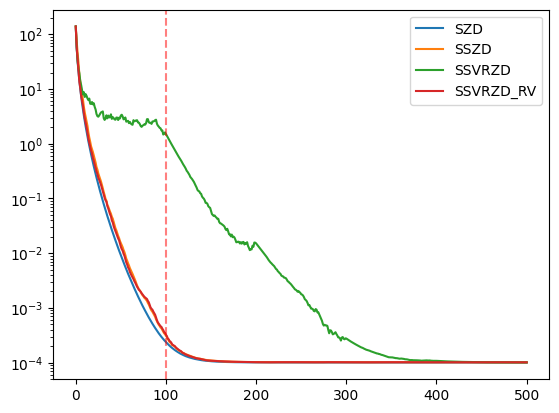

In [9]:
def compute_mean(results):
    results['szd'] = (np.mean(results['szd'], axis=0), np.std(results['szd'], axis=0))
    results['sszd'] = (np.mean(results['sszd'], axis=0), np.std(results['sszd'], axis=0))
    results['ssvrzd_full_iter'] = (np.mean(results['ssvrzd_full_iter'], axis=0), np.std(results['ssvrzd_full_iter'], axis=0))
    results['ssvrzd_only_iter'] = (np.mean(results['ssvrzd_only_iter'], axis=0), np.std(results['ssvrzd_only_iter'], axis=0))

compute_mean(results)    

fig, ax = plt.subplots()

ax.plot(range(len(results['szd'][0])), results['szd'][0], '-', label="SZD")
ax.plot(range(len(results['sszd'][0])), results['sszd'][0], '-', label="SSZD")
ax.plot(range(len(results['ssvrzd_full_iter'][0])), results['ssvrzd_full_iter'][0], '-', label='SSVRZD')
ax.plot(range(len(results['ssvrzd_only_iter'][0])), results['ssvrzd_only_iter'][0], '-', label='SSVRZD_RV')


ax.axvline(num_iters,linestyle='--', color="red", alpha=0.5)

ax.legend()
ax.set_yscale("log")

In [33]:
print(results['ssvrzd_full_iter'][0][:10], results['ssvrzd_only_iter'][0][:10])

[1.07196058e+04 6.59700727e+00 8.57291136e+02 9.16748084e+02
 6.25203618e+02 5.66588180e+02 6.35912455e+02 5.54608086e+02
 5.11637368e+02 5.01368084e+02] [1.07196058e+04 6.59700727e+00 1.25382275e+00 5.55721975e-01
 3.99473709e-01 3.46535434e-01 3.17887902e-01 3.03849620e-01
 2.79878733e-01 2.81293566e-01]
